# Final Exam - Group Portion - Supplementary Code Notebook
### Data Science for Biology
#### Authors: Qamil Mirza, Grayson, Skye, Jasleen

## Introduction
Activation domains (ADs) are short, disordered protein fragments capable of enhancing gene expression by recruiting components of the transcriptional machinery. Despite their importance, the relationship between AD sequence and function remains poorly understood due to the lack of conserved motifs and their intrinsic disorder. Traditional experimental screening approaches for identifying functional ADs are time-intensive and may fail to uncover subtle, high-dimensional sequence-function patterns. This project investigates whether machine learning models can be used alongside feature embeddings generated by large protein language models, in particular the Evolutionary Scale Model 2 (ESM2) developed by Facebook Artificial Intelligence Research (FAIR), to accurately predict AD activity and consequently be used to guide the design of synthetic ADs with higher functional output. 
Our central research question is: Does leveraging pre-trained protein language model embeddings improve the prediction of AD activity? Following this, are we then able to use this to discover subtle sequence-function relationships for designing these 40 amino acid protein fragments?

To address this, we focused on a dataset of 40 amino acid protein fragments with experimentally measured activity in both a Saccharomyces cerevisiae glucose (SCglucose) and Saccharomyces cerevisiae galactose (SCgalactose) reporter system. Many of these sequences exhibit low or undetectable activity, challenging sequence-based prediction models. Our work trains regression models on three primary types of features:

- Pre-Computed Features
- Pre-Computed Features + ESM2 Feature Embeddings
- ESM2 Feature Embeddings

We then select the best-performing model and perform in silico directed evolution to carry out pointwise mutagenesis to identify new candidate AD sequences predicted to have higher AD activity. We then provide a further analysis of the pointwise changes made, the changes in net charge, and net hydrophobicity. Additionally, we provide a residue disorder analysis computed with MetaPredict to ensure the intrinsic disordered nature of the protein is maintained

## Environment Setup

In [80]:
!mkdir models/glucose
!mkdir models/galactose
!mkdir feature-embeddings
!mkdir data/
!mkdir mutants/
!mkdir mutants/glucose
!mkdir mutants/galactose
!mv AltPromoterCounts.csv GCN4_SensuStrictuSeqsProtein.txt gcn4-orthologs.csv Table_S1_Unique_502_Gcn4_Seqs.fasta data/

mkdir: cannot create directory ‘models/glucose’: File exists


mkdir: cannot create directory ‘models/galactose’: File exists
mkdir: cannot create directory ‘feature-embeddings’: File exists
mkdir: cannot create directory ‘data/’: File exists
mv: cannot stat 'AltPromoterCounts.csv': No such file or directory
mv: cannot stat 'GCN4_SensuStrictuSeqsProtein.txt': No such file or directory
mv: cannot stat 'gcn4-orthologs.csv': No such file or directory
mv: cannot stat 'Table_S1_Unique_502_Gcn4_Seqs.fasta': No such file or directory


## Libraries and Packages

In [8]:
!pip install metapredict


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import metapredict as meta
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from scipy.stats import pearsonr

from transformers import AutoTokenizer, AutoModel
import torch
from dotenv import load_dotenv
import os
import numpy as np
from tqdm import tqdm
import joblib

# Set random seed
np.random.seed(42)

## Activity SCglucose Analysis & Model Development
We would like to give credit to Qamil Mirza and Grayson who worked on the analysis for this column together

### Data Loading

In [10]:
data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

tile_id                                             DNAseq  \
0        0  AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...   
1        1  AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...   
2        2  AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...   
3        3  AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...   
4        4  AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...   

                                      ADseq  numreads_per_AD_7AGFP_AAS  \
0  KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD                        NaN   
1  KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK                      942.0   
2  KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR                        NaN   
3  KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM                      357.0   
4  KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM                      539.0   

   Activity_7AGFP_AAS  numreads_per_AD_8AmCh_AAS  Activity_8AmCh_AAS  \
0                 NaN                        NaN                 NaN   
1          709.606092                      367.0         2921.917252   
2                 NaN                        NaN                 NaN   
3         1039.469842                      342.0         1089.428196   
4         1081.980998                      627.0          622.131501   

   numreads_per_AD_9ARatio_AAS  Activity_9ARatio_AAS  \
0                          NaN                   NaN   
1                        601.0           22242.74698   
2                          NaN                   NaN   
3                        450.0           74251.36241   
4                        586.0           58872.95132   

   numreads_per_AD_10BRatio_AAS  ...  Activity_BYS4_BioRepAverage  \
0                        3151.0  ...                          NaN   
1                        6909.0  ...                  21968.05843   
2                        6577.0  ...                          NaN   
3                           NaN  ...                          NaN   
4                         128.0  ...                  95093.69451   

  Stdev_BYS4_BioReps Activity_SCglucose  Start  Recovered  \
0                NaN        11666.48682    341       True   
1        5849.143385        21968.05843    146       True   
2                NaN        21203.02478    326       True   
3                NaN        47244.41248    246       True   
4       13292.686710        95093.69451    211       True   

   Activity_SCgalactose  Activity_P3promoter  Activity_P14promoter  \
0           97250.68362                  NaN           11149.49032   
1           15516.96245          14570.13217           16872.28649   
2               0.00000          18274.98241           15702.60901   
3           92844.00000                  NaN                   NaN   
4           76399.62949                  NaN          125056.17980   

   Activity_P15promoter  Activity_P3promoterMig1TFBSremoved  
0                   NaN                         8040.343648  
1           11555.08411                        10255.296840  
2           18303.29201                        17265.783330  
3                   NaN                        84807.518160  
4          129302.35080                       100360.735500  

[5 rows x 35 columns]

In [11]:
len(data.iloc[0, 2])

40

In [12]:
num_rows = data.shape[0]
num_cols = data.shape[1]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 19038
Number of columns: 35


### Data Exploration
First, we will start by analyzing the data for missing values

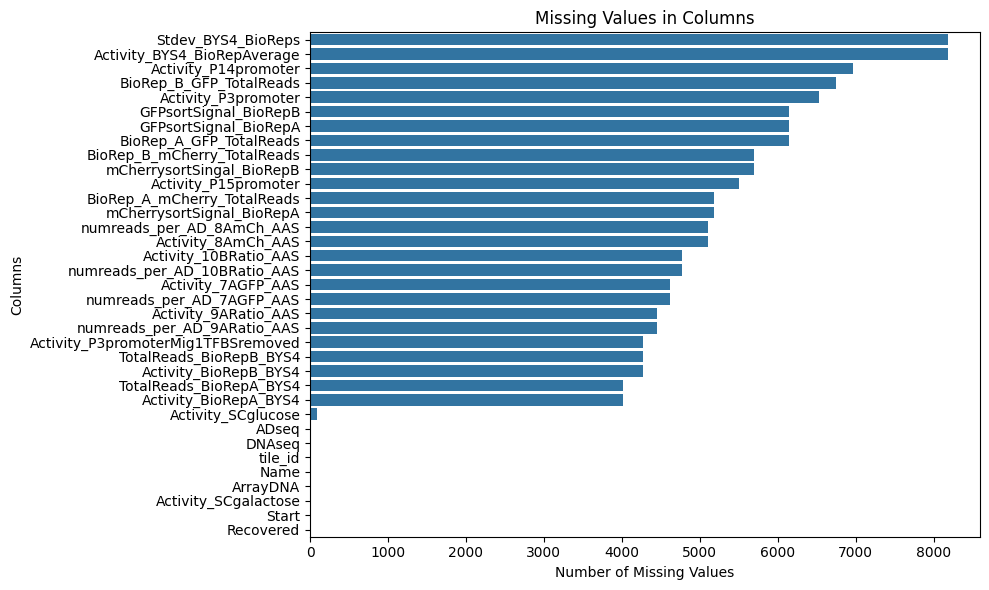

In [13]:
# Bar chart for missing values hprizontally
missing_values = data.isnull().sum()
#missing_values = missing_values[missing_values > 0]
missing_values = missing_values.sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.values, y=missing_values.index, orient="h")
plt.xlabel("Number of Missing Values")
plt.ylabel("Columns")
plt.title("Missing Values in Columns")
plt.tight_layout()
#plt.savefig("GCN4_missing_values.png")
plt.show()

There are quite a lot of zeroes but here we recall that the doc explicitly mentions that the tile with `NaN` activities really means that they were not measured at all. So, intuitively, it dos not make sense to treat these values as  zero-activity values since this would mislead our model into thinking that these tiles are just functionally silent.

As per the final project warmup, it will be good to only consider the rows with a higher sequencing reads since those with very low sequencing reads can be introduce noise when we begin modelling. To this end, we set a introduce a new hyperparameter `read_threshold` that will allow us to filter the dataset for rows with reads greater than or equal to the arbitrarily specified `read_threshold`

In [14]:
read_threshold = 1000 # threshold for read count

df_filtered = data[(data['TotalReads_BioRepA_BYS4'] >= read_threshold) & (data['TotalReads_BioRepB_BYS4'] >= read_threshold)]
print(f"Number of rows before filtering: {num_rows}")
print(f"Number of rows removed: {num_rows - df_filtered.shape[0]}")
print(f"Number of rows after filtering: {df_filtered.shape[0]}")

Number of rows before filtering: 19038
Number of rows removed: 9985
Number of rows after filtering: 9053


For a baseline model, we will use `Activity_SCglucose` as a baseline activity measurement since I believe the project doc mentioned it is the most well-characterized condition in the dataset. Since the project doc says that zeroes represent unmeasured quantities, I will drop these rows to prevent additional noise in our data

In [15]:
activity_col = "Activity_SCglucose"
df_filtered = df_filtered[df_filtered[activity_col] > 0]

print(f"Number of rows after filtering for non-zero {activity_col}: {df_filtered.shape[0]}")

Number of rows after filtering for non-zero Activity_SCglucose: 9053


I'll also quickly check if there are any duplicates in our data that may bias model metrics later on

In [16]:
# Check for duplicates
duplicates = df_filtered.duplicated(subset=["tile_id"], keep=False)
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [17]:
df_with_seq = df_filtered.copy()

## Feature Engineering
Section to add new features inferred from existing columns like net charge

In [18]:
# FEATURES

# variables I need glovally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [19]:
# Apply features to the filtered DataFrame
df_filtered = add_sequence_features(df_filtered)
df_filtered.iloc[:, 35:]

NetCharge  Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  \
1              6           -34.0      40     2     0     2     0     0     4   
7              1           -24.2      40     3     1     2     1     1     3   
8              2           -36.7      40     2     0     3     0     0     2   
12            -4           -13.8      40     6     0     4     2     4     3   
18             6           -24.4      40     5     0     0     1     2     0   
...          ...             ...     ...   ...   ...   ...   ...   ...   ...   
19021         -1           -33.9      40     2     0     3     1     4     0   
19030         -6            19.9      40     3     1     6     0     3     1   
19033         -7           -42.3      40     1     0     5     3     2     2   
19036          2            27.8      40     5     2     1     0     2     3   
19037         -4           -14.4      40     1     0     4     1     4     2   

       AA_H  ...  DE_WF  DE_L  DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  \
1         1  ...      0     0         0          0   0    0     0         0   
7         3  ...      0     0         0          0   0    0     0         0   
8         1  ...      0     0         1          0   0    0     0         0   
12        0  ...      1     3         0          1   0    0     1         0   
18        1  ...      0     0         0          0   0    0     0         0   
...     ...  ...    ...   ...       ...        ...  ..  ...   ...       ...   
19021     4  ...      1     0         0          1   0    0     1         0   
19030     0  ...      0     1         0          1   0    0     0         0   
19033     1  ...      0     1         1          1   0    0     0         0   
19036     2  ...      0     0         0          0   0    0     0         0   
19037     2  ...      0     2         0          0   0    0     0         1   

       SP  WFYL_3x_WFYL  
1       1             0  
7       0             0  
8       2             0  
12      1             0  
18      1             0  
...    ..           ...  
19021   1             0  
19030   0             0  
19033   1             0  
19036   1             0  
19037   1             0  

[9053 rows x 37 columns]

## Feature Selection

In [20]:
X = df_filtered.iloc[:, 35:]
y = df_filtered[activity_col]


# now i structure the final prep data
df = pd.concat([X, y], axis=1)

assert df.isna().sum().sum() == 0, "Features contain NaNs"

# quick sanity check for missing values
print("Missing values in final data:")
print(df.isnull().sum())

Missing values in final data:
NetCharge             0
Hydrophobicity        0
Length                0
AA_A                  0
AA_C                  0
AA_D                  0
AA_E                  0
AA_F                  0
AA_G                  0
AA_H                  0
AA_I                  0
AA_K                  0
AA_L                  0
AA_M                  0
AA_N                  0
AA_P                  0
AA_Q                  0
AA_R                  0
AA_S                  0
AA_T                  0
AA_V                  0
AA_W                  0
AA_Y                  0
W..LF                 0
WFYL_WFYL             0
WFL_WFL               0
DE_WFY                0
DE_WF                 0
DE_L                  0
DE_x_WFY              0
DE_xx_WFY             0
FF                    0
F_F                   0
F__F                  0
FY_5x_FY              0
SP                    0
WFYL_3x_WFYL          0
Activity_SCglucose    0
dtype: int64


In [21]:
df.head()

NetCharge  Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  \
1           6           -34.0      40     2     0     2     0     0     4   
7           1           -24.2      40     3     1     2     1     1     3   
8           2           -36.7      40     2     0     3     0     0     2   
12         -4           -13.8      40     6     0     4     2     4     3   
18          6           -24.4      40     5     0     0     1     2     0   

    AA_H  ...  DE_L  DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  \
1      1  ...     0         0          0   0    0     0         0   1   
7      3  ...     0         0          0   0    0     0         0   0   
8      1  ...     0         1          0   0    0     0         0   2   
12     0  ...     3         0          1   0    0     1         0   1   
18     1  ...     0         0          0   0    0     0         0   1   

    WFYL_3x_WFYL  Activity_SCglucose  
1              0         21968.05843  
7              0         70876.84864  
8              0         16850.74599  
12             0        226681.83670  
18             0         33491.53797  

[5 rows x 38 columns]

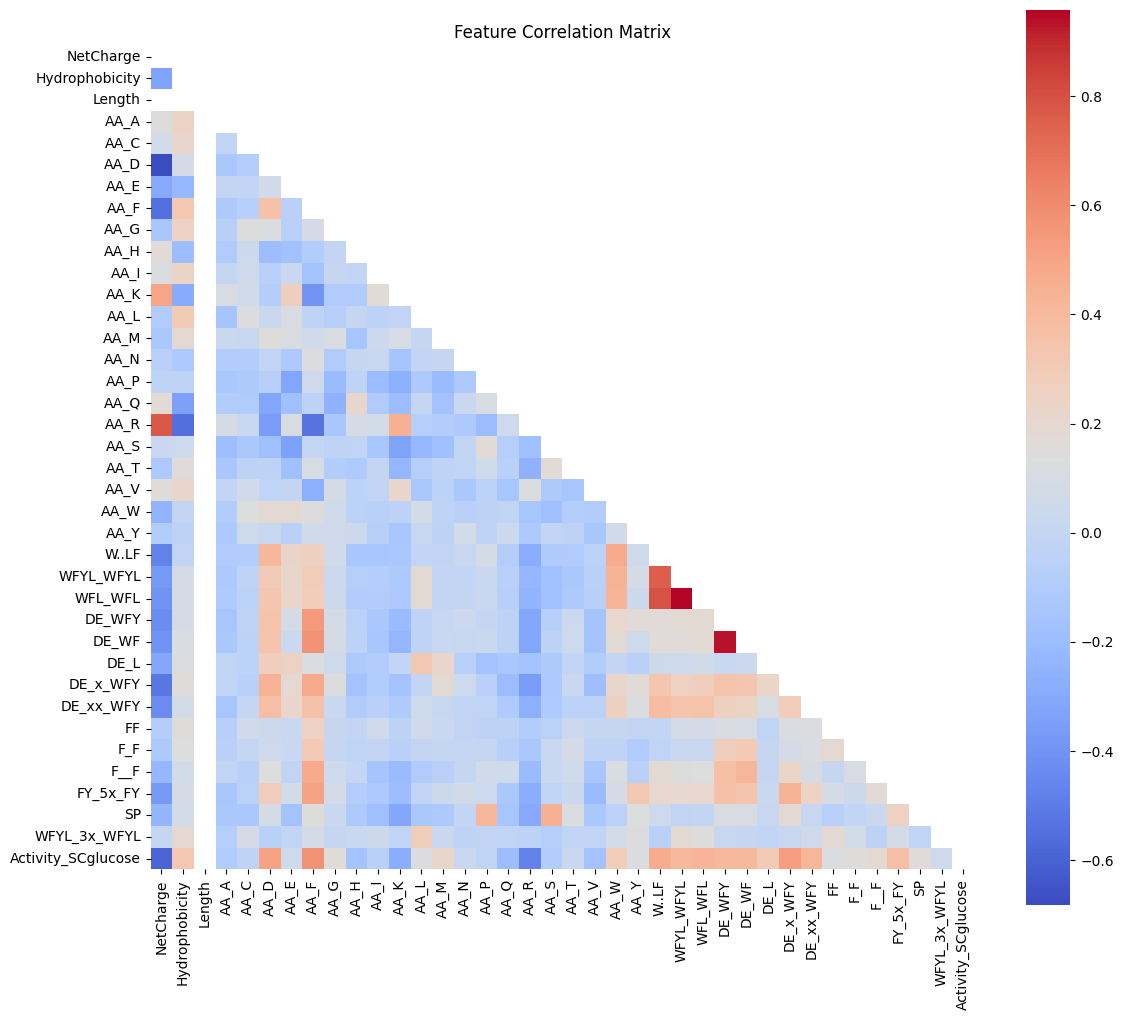

In [22]:
# Check correlation matrix
plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
#plt.savefig("GCN4_correlation_matrix.png")
plt.show()

In [23]:
# Get top 10 positive and negative correlations with the target variable
corr_target = df.corr()[activity_col].sort_values(ascending=False)
top_10_positive = corr_target.head(10)
top_10_negative = corr_target.tail(10)
print("Top 10 positive correlations with target:")
print(top_10_positive)

print("="*50)

print("Top 10 negative correlations with target:")
print(top_10_negative)

Top 10 positive correlations with target:
Activity_SCglucose    1.000000
AA_F                  0.578342
DE_x_WFY              0.529104
AA_D                  0.513607
W..LF                 0.465606
WFL_WFL               0.431691
DE_xx_WFY             0.422044
WFYL_WFYL             0.408972
DE_WFY                0.408531
DE_WF                 0.401886
Name: Activity_SCglucose, dtype: float64
Top 10 negative correlations with target:
AA_I        -0.062509
AA_S        -0.088594
AA_A        -0.101470
AA_H        -0.158249
AA_V        -0.164977
AA_Q        -0.198470
AA_K        -0.281673
AA_R        -0.473222
NetCharge   -0.588060
Length            NaN
Name: Activity_SCglucose, dtype: float64


## Baseline Model Development

In typical ML fashion, we begin by splitting our data into a train and test set. Also, since the target values are much higher than our engineered features, we will have to scale it appropriately. I'm just going to use Z-Score normalization which is implemented out of the box via sklearn's `StandardScaler` class.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cool, now that we have train and test set, we're going to build multiple baseline models, I will build the following:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Gradient Boosted Regressor
- Random Forest Regressor
- ElasticNet

In [25]:
linear_reg = make_pipeline(StandardScaler(), LinearRegression())
linear_reg.fit(X_train, y_train)
linear_reg_y_pred = linear_reg.predict(X_test)

print("Linear Regression Results:")
print(f"R^2: {r2_score(y_test, linear_reg_y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, linear_reg_y_pred):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test, linear_reg_y_pred):.4f}")
print(f"Pearson Correlation: {pearsonr(y_test, linear_reg_y_pred)[0]:.4f}")

Linear Regression Results:
R^2: 0.6195
MAE: 29117.0950
RMSE: 39797.4656
Pearson Correlation: 0.7875


In [26]:
ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg.fit(X_train, y_train)
ridge_reg_y_pred = ridge_reg.predict(X_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_test, ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.6201281103997202
MAE: 28987.144163384466
RMSE: 39767.08032290962
Pearson Correlation: 0.7876414833027815


In [27]:
lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg.fit(X_train, y_train)
lasso_reg_y_pred = lasso_reg.predict(X_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_test, lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.6201318526495319
MAE: 28986.773807345686
RMSE: 39766.88444277287
Pearson Correlation: 0.7876439144538867


In [28]:
grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg.fit(X_train, y_train)
grad_boost_reg_y_pred = grad_boost_reg.predict(X_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_test, grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.753700802349068
MAE: 22520.370014086355
RMSE: 32021.127989379256
Pearson Correlation: 0.8700241578562002


In [29]:
random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg.fit(X_train, y_train)
random_forest_y_pred = random_forest_reg.predict(X_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_test, random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7961507641413464
MAE: 20054.764553828776
RMSE: 29131.28699844031
Pearson Correlation: 0.8929759233179536


In [30]:
elastic_reg = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000))
elastic_reg.fit(X_train, y_train)
elastic_reg_y_pred = elastic_reg.predict(X_test)

print("Elastic Net Regression Results:")
print(f"R^2: {r2_score(y_test, elastic_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, elastic_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_test, elastic_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_test, elastic_reg_y_pred)[0]}")

Elastic Net Regression Results:
R^2: 0.5958680021266148
MAE: 29412.519209197613
RMSE: 41017.26956183963
Pearson Correlation: 0.775792190812657


### Baseline Model Evaluation

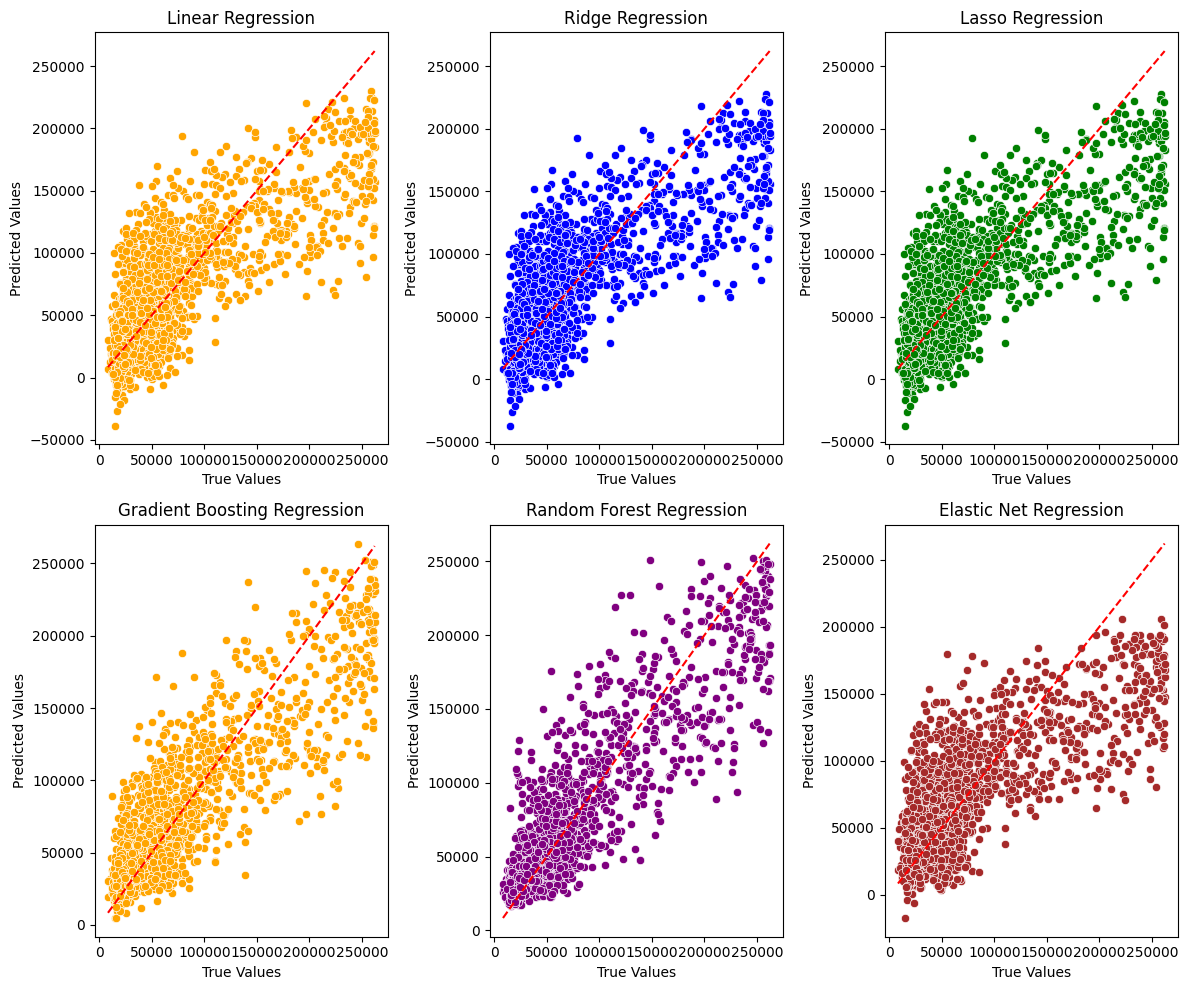

In [31]:
# Make subplots for each model
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Linear Regression
sns.scatterplot(x=y_test, y=linear_reg_y_pred, ax=axes[0], color='orange')
axes[0].set_title("Linear Regression")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[0], color='red', linestyle='--')

# Ridge Regression
sns.scatterplot(x=y_test, y=ridge_reg_y_pred, ax=axes[1], color='blue')
axes[1].set_title("Ridge Regression")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[1], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_test, y=lasso_reg_y_pred, ax=axes[2], color='green')
axes[2].set_title("Lasso Regression")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[2], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_test, y=grad_boost_reg_y_pred, ax=axes[3], color='orange')
axes[3].set_title("Gradient Boosting Regression")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[3], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_test, y=random_forest_y_pred, ax=axes[4], color='purple')
axes[4].set_title("Random Forest Regression")
axes[4].set_xlabel("True Values")
axes[4].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[4], color='red', linestyle='--')

# Elastic Net Regression
sns.scatterplot(x=y_test, y=elastic_reg_y_pred, ax=axes[5], color='brown')
axes[5].set_title("Elastic Net Regression")
axes[5].set_xlabel("True Values")
axes[5].set_ylabel("Predicted Values")
sns.lineplot(x=y_test, y=y_test, ax=axes[5], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [32]:
# Make df of results
results = {
    "Model": ["Linear", "Ridge", "Lasso", "Gradient Boosting", "Random Forest", "Elastic Net"],
    "R^2": [
        r2_score(y_test, linear_reg_y_pred),
        r2_score(y_test, ridge_reg_y_pred),
        r2_score(y_test, lasso_reg_y_pred),
        r2_score(y_test, grad_boost_reg_y_pred),
        r2_score(y_test, random_forest_y_pred),
        r2_score(y_test, elastic_reg_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_test, linear_reg_y_pred),
        mean_absolute_error(y_test, ridge_reg_y_pred),
        mean_absolute_error(y_test, lasso_reg_y_pred),
        mean_absolute_error(y_test, grad_boost_reg_y_pred),
        mean_absolute_error(y_test, random_forest_y_pred),
        mean_absolute_error(y_test, elastic_reg_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_test, linear_reg_y_pred),
        root_mean_squared_error(y_test, ridge_reg_y_pred),
        root_mean_squared_error(y_test, lasso_reg_y_pred),
        root_mean_squared_error(y_test, grad_boost_reg_y_pred),
        root_mean_squared_error(y_test, random_forest_y_pred),
        root_mean_squared_error(y_test, elastic_reg_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_test, linear_reg_y_pred)[0],
        pearsonr(y_test, ridge_reg_y_pred)[0],
        pearsonr(y_test, lasso_reg_y_pred)[0],
        pearsonr(y_test, grad_boost_reg_y_pred)[0],
        pearsonr(y_test, random_forest_y_pred)[0],
        pearsonr(y_test, elastic_reg_y_pred)[0]
    ]
}
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
results_df.head(6)

Model       R^2           MAE          RMSE  \
0      Random Forest  0.796151  20054.764554  29131.286998   
1  Gradient Boosting  0.753701  22520.370014  32021.127989   
2              Lasso  0.620132  28986.773807  39766.884443   
3              Ridge  0.620128  28987.144163  39767.080323   
4             Linear  0.619547  29117.094969  39797.465600   
5        Elastic Net  0.595868  29412.519209  41017.269562   

   Pearson Correlation  
0             0.892976  
1             0.870024  
2             0.787644  
3             0.787641  
4             0.787452  
5             0.775792

In [33]:
# Save the model
joblib.dump(random_forest_reg, "./models/glucose/random_forest_model.pkl")

['./models/glucose/random_forest_model.pkl']

## Feature Importances Analysis

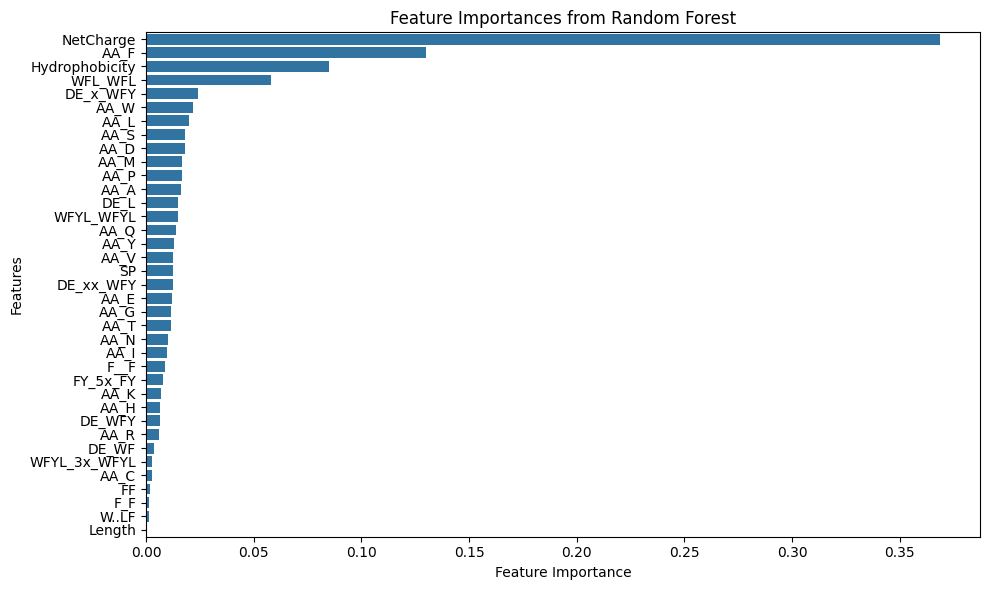

In [34]:
feature_importances = random_forest_reg.named_steps['randomforestregressor'].feature_importances_
feature_names = X.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

## Protein Language Model (PLM) Features

Here I will be utilizing the Evolutionary Scale Model 2 produced by Facebook AI Research. In particular, I will be utilizing the 8M parameter version to generate feature-rich embeddings to train some baseline models. We set load the model below and run it on inference mode to generate these embeddings. To ensure this runs without any issues, please ensure you have set the `HF_TOKEN` in the .env file!

We will first augment our existing engineered features with these embeddings, and below I will perform an ablation study for further analysis on which features actually mattered

### Feature Extraction

In [ ]:
# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

# Comment out when not needed
save_embeddings_to_npz(df_with_seq, sequence_column="ADseq", save_path="./feature-embeddings/esm2_embeddings_scglucose.npz")


/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 9053/9053 [02:26<00:00, 62.00it/s] 


Saved 9053 embeddings to ./feature-embeddings/esm2_embeddings.npz


### Training Baseline Models With PLM Embeddings

In [36]:
# Load the embeddings from the NPZ file
embeddings_data = np.load("./feature-embeddings/esm2_embeddings_scglucose.npz")
embeddings = embeddings_data["embeddings"]

# Check the shape of the loaded embeddings
print(f"Loaded embeddings shape: {embeddings.shape}")

Loaded embeddings shape: (9053, 320)


In [37]:
# Prep embededings into a dataframe for feature concatenation
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.columns = [f"embedding_{i}" for i in range(embeddings_df.shape[1])]
embeddings_df.head(3)

embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0    -0.025192    -0.386163     0.038171     0.142583     0.045324   
1     0.014334    -0.416917     0.232792     0.121774    -0.028585   
2    -0.005063    -0.397236    -0.005174     0.114196     0.172707   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0    -0.185973    -0.089887     0.023278    -0.155760    -0.039424  ...   
1    -0.204531    -0.152476     0.021117    -0.132263    -0.106221  ...   
2    -0.098770    -0.020182     0.004256    -0.168792    -0.136290  ...   

   embedding_310  embedding_311  embedding_312  embedding_313  embedding_314  \
0       0.242718      -0.096438       0.113960       0.213151      -0.079959   
1       0.087891      -0.152725       0.103766       0.121723      -0.077505   
2       0.192599      -0.115246       0.148075       0.255852      -0.075508   

   embedding_315  embedding_316  embedding_317  embedding_318  embedding_319  
0       0.146884      -0.072922       0.234120      -0.032808       0.050551  
1       0.077167      -0.150012       0.081626       0.134874       0.011173  
2       0.183582      -0.043454       0.221282       0.090849       0.028793  

[3 rows x 320 columns]

In [38]:
# the assert below is for me to chek for dimension mismatch
assert embeddings_df.shape[0] == df_filtered.shape[0], "Mismatch in number of rows between embeddings and original DataFrame"

# Concatenate the embeddings with the original DataFrame
X_esm = pd.concat([X.reset_index(drop=True),
                   embeddings_df.reset_index(drop=True)],
                  axis=1)
y_esm = y.copy()

print(f"X_esm shape: {X_esm.shape}")
print(f"y_esm shape: {y_esm.shape}")

X_esm shape: (9053, 357)
y_esm shape: (9053,)


In [39]:
X_esm_train, X_esm_test, y_esm_train, y_esm_test = train_test_split(X_esm, y_esm, test_size=0.2, random_state=42)

In [40]:
esm_linear_reg = make_pipeline(StandardScaler(), LinearRegression())
esm_linear_reg.fit(X_esm_train, y_esm_train)
esm_linear_reg_y_pred = esm_linear_reg.predict(X_esm_test)

print("Linear Regression with ESM Embeddings Results:")
print(f"R^2: {r2_score(y_esm_test, esm_linear_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_linear_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_linear_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_linear_reg_y_pred)[0]}")

Linear Regression with ESM Embeddings Results:
R^2: 0.7491271141437714
MAE: 24150.929746736583
RMSE: 32317.070880326704
Pearson Correlation: 0.865571350027353


In [41]:
esm_ridge_reg = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
esm_ridge_reg.fit(X_esm_train, y_esm_train)
esm_ridge_reg_y_pred = esm_ridge_reg.predict(X_esm_test)

#  just print for now
print("Ridge Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_ridge_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_ridge_reg_y_pred)[0]}")

Ridge Regression Results:
R^2: 0.7511689855279073
MAE: 24034.42004925025
RMSE: 32185.286769800612
Pearson Correlation: 0.8667569536805928


In [42]:
esm_lasso_reg = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
esm_lasso_reg.fit(X_esm_train, y_esm_train)
esm_lasso_reg_y_pred = esm_lasso_reg.predict(X_esm_test)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_lasso_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_lasso_reg_y_pred)[0]}")

Lasso Regression Results:
R^2: 0.7510949161147215
MAE: 24038.644276263833
RMSE: 32190.0767030988
Pearson Correlation: 0.8667134451972629


In [43]:
esm_random_forest_reg = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
esm_random_forest_reg.fit(X_esm_train, y_esm_train)
esm_random_forest_y_pred = esm_random_forest_reg.predict(X_esm_test)

print("Random Forest Regressor Results:")
print(f"R^2: {r2_score(y_esm_test, esm_random_forest_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_random_forest_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_random_forest_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_random_forest_y_pred)[0]}")

Random Forest Regressor Results:
R^2: 0.7835303977910969
MAE: 21023.834547198785
RMSE: 30019.509197396503
Pearson Correlation: 0.8880259233277831


In [44]:
esm_grad_boost_reg = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
esm_grad_boost_reg.fit(X_esm_train, y_esm_train)
esm_grad_boost_reg_y_pred = esm_grad_boost_reg.predict(X_esm_test)

print("Gradient Boosting Regressor Results:")
print(f"R^2: {r2_score(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_grad_boost_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_grad_boost_reg_y_pred)[0]}")

Gradient Boosting Regressor Results:
R^2: 0.7703598638819741
MAE: 21776.798479821453
RMSE: 30919.25533619557
Pearson Correlation: 0.8782237127326246


In [45]:
esm_elastic_reg = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000))
esm_elastic_reg.fit(X_esm_train, y_esm_train)
esm_elastic_reg_y_pred = esm_elastic_reg.predict(X_esm_test)

print("Elastic Net Regression Results:")
print(f"R^2: {r2_score(y_esm_test, esm_elastic_reg_y_pred)}")
print(f"MAE: {mean_absolute_error(y_esm_test, esm_elastic_reg_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test, esm_elastic_reg_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test, esm_elastic_reg_y_pred)[0]}")

Elastic Net Regression Results:
R^2: 0.6829715288137845
MAE: 26313.43846161449
RMSE: 36329.06839323635
Pearson Correlation: 0.8285478507566912


### Result Analysis: Features Augmented With PLM Embeddings

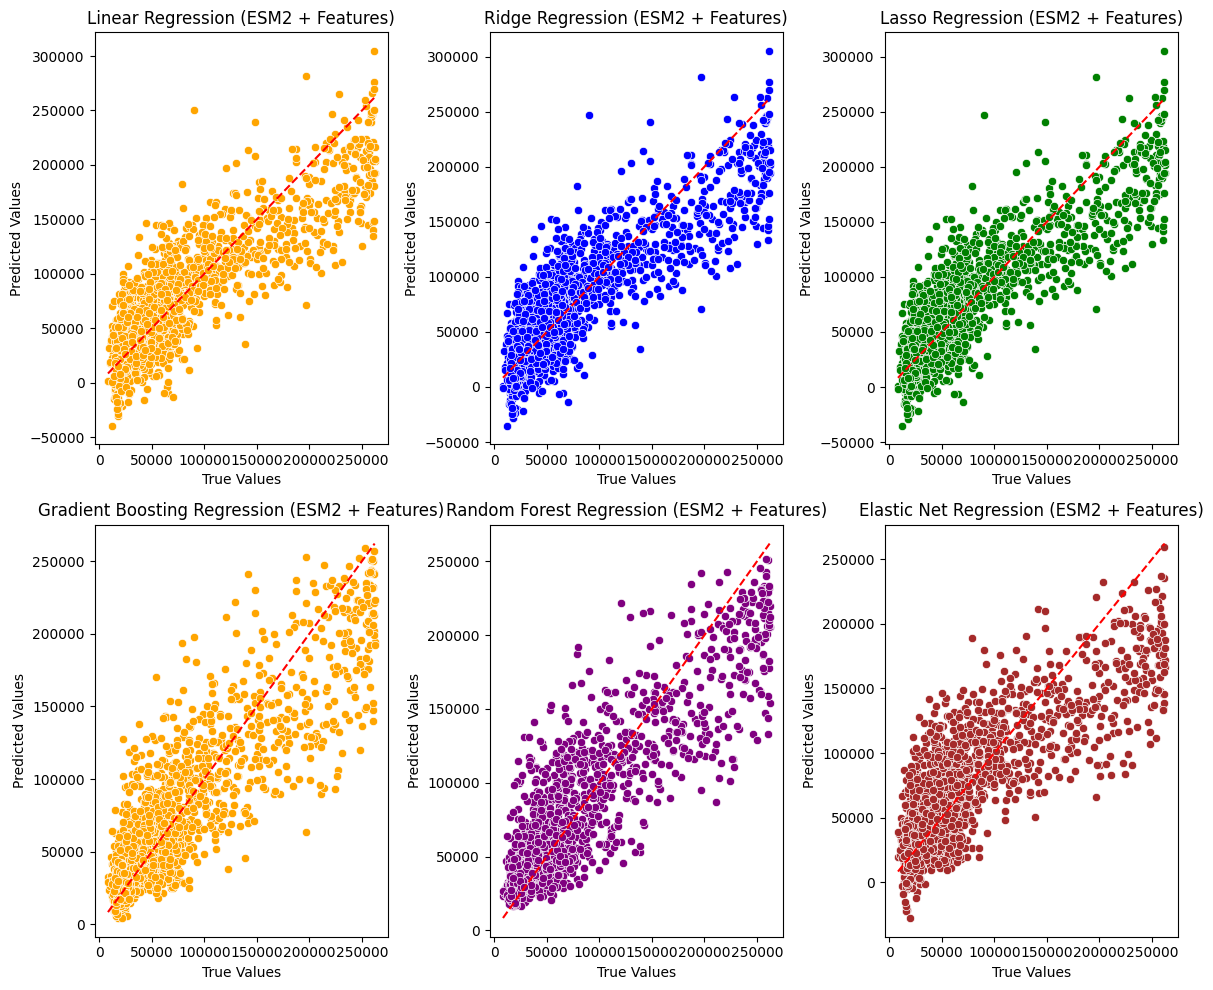

In [46]:
# Make subplots for each model
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Linear Regression
sns.scatterplot(x=y_esm_test, y=esm_linear_reg_y_pred, ax=axes[0], color='orange')
axes[0].set_title("Linear Regression (ESM2 + Features)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[0], color='red', linestyle='--')

# Ridge Regression
sns.scatterplot(x=y_esm_test, y=esm_ridge_reg_y_pred, ax=axes[1], color='blue')
axes[1].set_title("Ridge Regression (ESM2 + Features)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[1], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_esm_test, y=esm_lasso_reg_y_pred, ax=axes[2], color='green')
axes[2].set_title("Lasso Regression (ESM2 + Features)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[2], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_esm_test, y=esm_grad_boost_reg_y_pred, ax=axes[3], color='orange')
axes[3].set_title("Gradient Boosting Regression (ESM2 + Features)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[3], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_esm_test, y=esm_random_forest_y_pred, ax=axes[4], color='purple')
axes[4].set_title("Random Forest Regression (ESM2 + Features)")
axes[4].set_xlabel("True Values")
axes[4].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[4], color='red', linestyle='--')

# Elastic Net Regression
sns.scatterplot(x=y_esm_test, y=esm_elastic_reg_y_pred, ax=axes[5], color='brown')
axes[5].set_title("Elastic Net Regression (ESM2 + Features)")
axes[5].set_xlabel("True Values")
axes[5].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test, y=y_esm_test, ax=axes[5], color='red', linestyle='--')

plt.tight_layout()
plt.show()


In [47]:
# Make df of results
esm_results = {
    "Model": ["Linear (ESM)", "Ridge (ESM)", "Lasso (ESM)", "Gradient Boosting (ESM)", "Random Forest (ESM)", "Elastic Net (ESM)"],
    "R^2": [
        r2_score(y_esm_test, esm_linear_reg_y_pred),
        r2_score(y_esm_test, esm_ridge_reg_y_pred),
        r2_score(y_esm_test, esm_lasso_reg_y_pred),
        r2_score(y_esm_test, esm_grad_boost_reg_y_pred),
        r2_score(y_esm_test, esm_random_forest_y_pred),
        r2_score(y_esm_test, esm_elastic_reg_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_esm_test, esm_linear_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_ridge_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_lasso_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_grad_boost_reg_y_pred),
        mean_absolute_error(y_esm_test, esm_random_forest_y_pred),
        mean_absolute_error(y_esm_test, esm_elastic_reg_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_esm_test, esm_linear_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_ridge_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_lasso_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_grad_boost_reg_y_pred),
        root_mean_squared_error(y_esm_test, esm_random_forest_y_pred),
        root_mean_squared_error(y_esm_test, esm_elastic_reg_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_esm_test, esm_linear_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_ridge_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_lasso_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_grad_boost_reg_y_pred)[0],
        pearsonr(y_esm_test, esm_random_forest_y_pred)[0],
        pearsonr(y_esm_test, esm_elastic_reg_y_pred)[0]
    ]
}
esm_results_df = pd.DataFrame(esm_results)
esm_results_df = esm_results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
esm_results_df.head(6)

Model       R^2           MAE          RMSE  \
0      Random Forest (ESM)  0.783530  21023.834547  30019.509197   
1  Gradient Boosting (ESM)  0.770360  21776.798480  30919.255336   
2              Ridge (ESM)  0.751169  24034.420049  32185.286770   
3              Lasso (ESM)  0.751095  24038.644276  32190.076703   
4             Linear (ESM)  0.749127  24150.929747  32317.070880   
5        Elastic Net (ESM)  0.682972  26313.438462  36329.068393   

   Pearson Correlation  
0             0.888026  
1             0.878224  
2             0.866757  
3             0.866713  
4             0.865571  
5             0.828548

### Analyzing Model Feature Importances

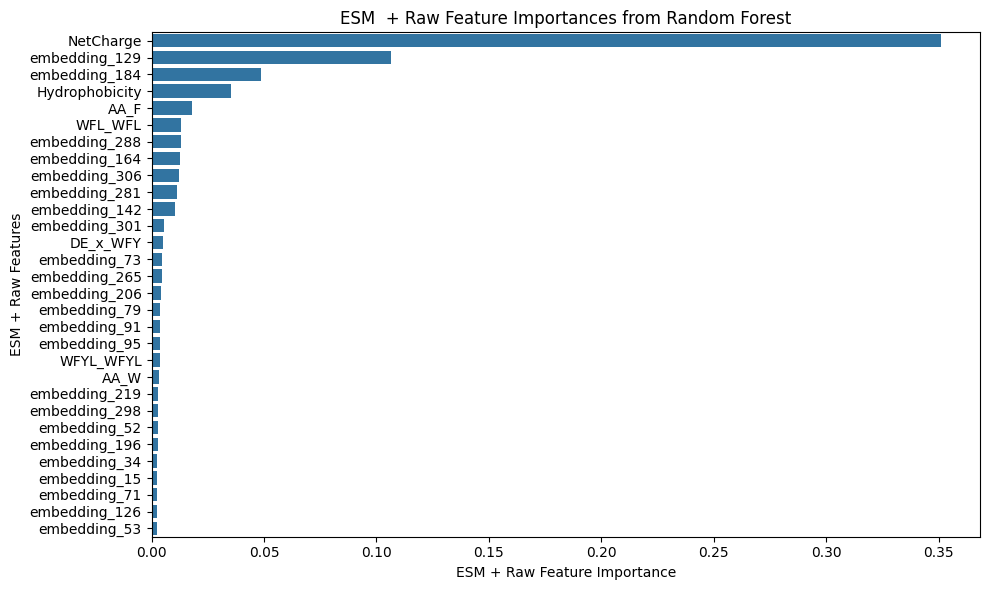

In [48]:
esm_feature_importances = esm_random_forest_reg.named_steps['randomforestregressor'].feature_importances_
esm_feature_names = X_esm.columns
esm_sorted_indices = np.argsort(esm_feature_importances)[::-1]

top_k = 30

sorted_esm_feature_importances = esm_feature_importances[esm_sorted_indices][:top_k]
sorted_esm_feature_names = esm_feature_names[esm_sorted_indices][:top_k]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_esm_feature_importances, y=sorted_esm_feature_names)
plt.xlabel("ESM + Raw Feature Importance")
plt.ylabel("ESM + Raw Features")
plt.title("ESM  + Raw Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

In [49]:
# Save the best model
import joblib
joblib.dump(esm_random_forest_reg, "./models/glucose/esm_random_forest_model.pkl")

['./models/glucose/esm_random_forest_model.pkl']

### Model Baseline With ONLY ESM Embeddings

In [50]:
X_only_embeddings = embeddings_df.copy()
y_only_embeddings = y.copy()

In [51]:
X_only_embeddings_train, X_only_embeddings_test, y_only_embeddings_train, y_only_embeddings_test = train_test_split(X_only_embeddings, y_only_embeddings, test_size=0.2, random_state=42)

In [52]:
# Linear Regression
linear_reg_embeddings = make_pipeline(StandardScaler(), LinearRegression())
linear_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
linear_reg_embeddings_y_pred = linear_reg_embeddings.predict(X_only_embeddings_test)
print("Linear Regression with ESM Embeddings Results:")
print(f"R^2: {r2_score(y_only_embeddings_test, linear_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, linear_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, linear_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, linear_reg_embeddings_y_pred)[0]}")

Linear Regression with ESM Embeddings Results:
R^2: 0.7348105521610881
MAE: 24932.293736655993
RMSE: 33226.396817679895
Pearson Correlation: 0.8572829011805787


In [53]:
# Ridge Regression
ridge_reg_embeddings = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
ridge_reg_embeddings_y_pred = ridge_reg_embeddings.predict(X_only_embeddings_test)
print("Ridge Regression Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, ridge_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, ridge_reg_embeddings_y_pred)[0]}")

Ridge Regression Results (Only ESM2):
R^2: 0.735239682558581
MAE: 24905.909391187324
RMSE: 33199.50240326854
Pearson Correlation: 0.8575259492432534


In [54]:
# Lasso
lasso_reg_embeddings = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
lasso_reg_embeddings_y_pred = lasso_reg_embeddings.predict(X_only_embeddings_test)
print("Lasso Regression Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, lasso_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, lasso_reg_embeddings_y_pred)[0]}")

Lasso Regression Results (Only ESM2):
R^2: 0.7350513743929454
MAE: 24916.35283654417
RMSE: 33211.30671410989
Pearson Correlation: 0.857417452990231


In [55]:
# Gradient Boosting
grad_boost_reg_embeddings = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
grad_boost_reg_embeddings_y_pred = grad_boost_reg_embeddings.predict(X_only_embeddings_test)
print("Gradient Boosting Regressor Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)[0]}")

Gradient Boosting Regressor Results (Only ESM2):
R^2: 0.7441358297140092
MAE: 22890.40820124309
RMSE: 32636.972459616703
Pearson Correlation: 0.8633379472200106


In [56]:
# Random Forest Regression
random_forest_reg_embeddings = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
random_forest_reg_embeddings_y_pred = random_forest_reg_embeddings.predict(X_only_embeddings_test)
print("Random Forest Regressor Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)[0]}")

Random Forest Regressor Results (Only ESM2):
R^2: 0.7624151682195077
MAE: 21832.59651112781
RMSE: 31449.553437317725
Pearson Correlation: 0.877963381626379


In [57]:
# Elastic Net
elastic_reg_embeddings = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000))
elastic_reg_embeddings.fit(X_only_embeddings_train, y_only_embeddings_train)
elastic_reg_embeddings_y_pred = elastic_reg_embeddings.predict(X_only_embeddings_test)
print("Elastic Net Regression Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test, elastic_reg_embeddings_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test, elastic_reg_embeddings_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test, elastic_reg_embeddings_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test, elastic_reg_embeddings_y_pred)[0]}")

Elastic Net Regression Results (Only ESM2):
R^2: 0.6530418970900533
MAE: 27943.1754142384
RMSE: 38005.25450918412
Pearson Correlation: 0.811064068709203


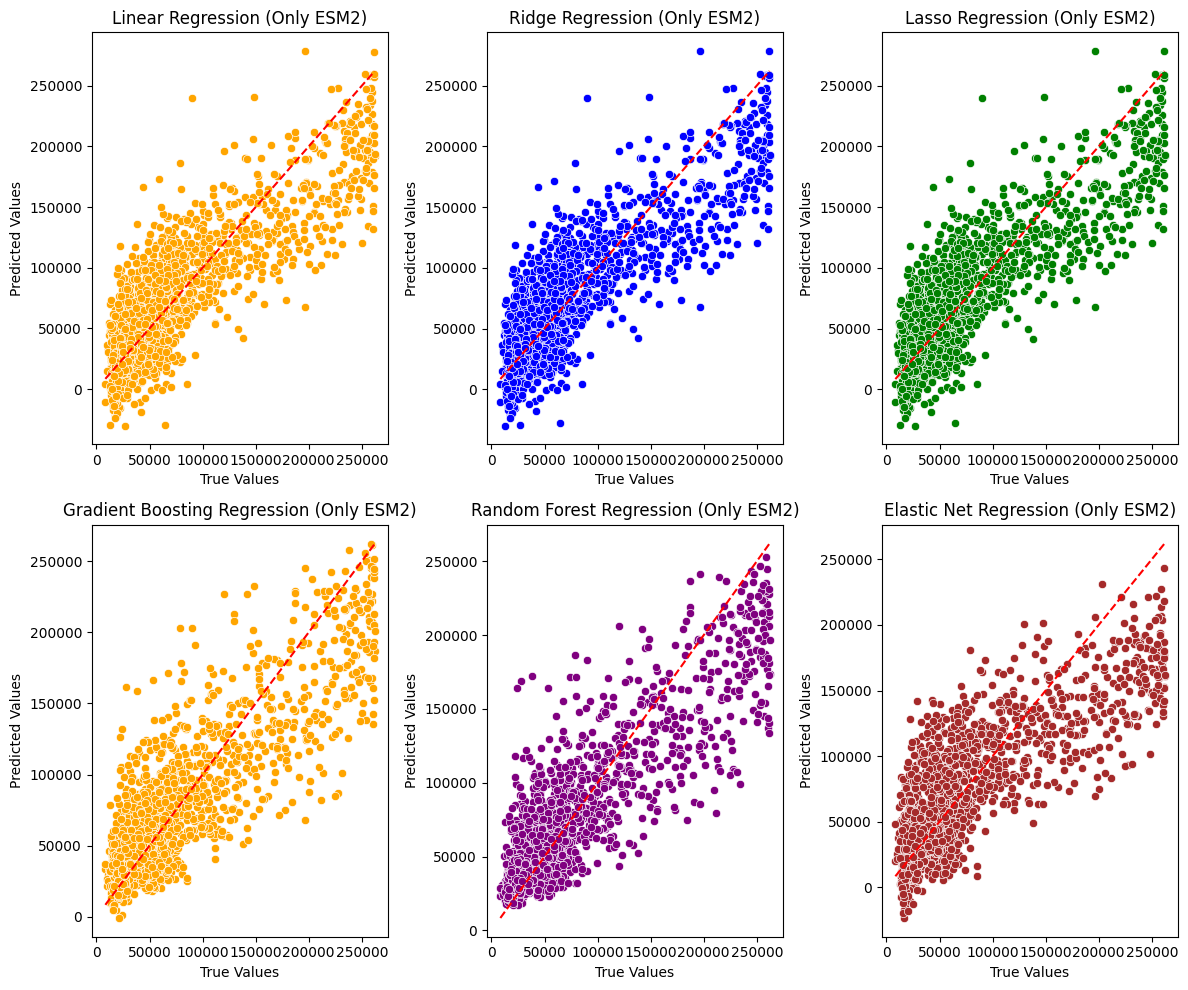

In [58]:
# subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 10))
axes = axes.flatten()

# Linear Regression
sns.scatterplot(x=y_only_embeddings_test, y=linear_reg_embeddings_y_pred, ax=axes[0], color='orange')
axes[0].set_title("Linear Regression (Only ESM2)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[0], color='red', linestyle='--')

# Ridge Regression
sns.scatterplot(x=y_only_embeddings_test, y=ridge_reg_embeddings_y_pred, ax=axes[1], color='blue')
axes[1].set_title("Ridge Regression (Only ESM2)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[1], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_only_embeddings_test, y=lasso_reg_embeddings_y_pred, ax=axes[2], color='green')
axes[2].set_title("Lasso Regression (Only ESM2)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[2], color='red', linestyle='--')

# Gradient Boosting Regression
sns.scatterplot(x=y_only_embeddings_test, y=grad_boost_reg_embeddings_y_pred, ax=axes[3], color='orange')
axes[3].set_title("Gradient Boosting Regression (Only ESM2)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[3], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_only_embeddings_test, y=random_forest_reg_embeddings_y_pred, ax=axes[4], color='purple')
axes[4].set_title("Random Forest Regression (Only ESM2)")
axes[4].set_xlabel("True Values")
axes[4].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[4], color='red', linestyle='--')

# Elastic Net Regression
sns.scatterplot(x=y_only_embeddings_test, y=elastic_reg_embeddings_y_pred, ax=axes[5], color='brown')
axes[5].set_title("Elastic Net Regression (Only ESM2)")
axes[5].set_xlabel("True Values")
axes[5].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test, y=y_only_embeddings_test, ax=axes[5], color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [59]:
# Make results df
only_embeddings_results = {
    "Model": ["Linear (Only ESM2)", "Ridge (Only ESM2)", "Lasso (Only ESM2)", "Gradient Boosting (Only ESM2)", "Random Forest (Only ESM2)", "Elastic Net (Only ESM2)"],
    "R^2": [
        r2_score(y_only_embeddings_test, linear_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, ridge_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, lasso_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, random_forest_reg_embeddings_y_pred),
        r2_score(y_only_embeddings_test, elastic_reg_embeddings_y_pred)
    ],
    "MAE": [
        mean_absolute_error(y_only_embeddings_test, linear_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred),
        mean_absolute_error(y_only_embeddings_test, elastic_reg_embeddings_y_pred)
    ],
    "RMSE": [
        root_mean_squared_error(y_only_embeddings_test, linear_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, ridge_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, lasso_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, random_forest_reg_embeddings_y_pred),
        root_mean_squared_error(y_only_embeddings_test, elastic_reg_embeddings_y_pred)
    ],
    "Pearson Correlation": [
        pearsonr(y_only_embeddings_test, linear_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, ridge_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, lasso_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, grad_boost_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, random_forest_reg_embeddings_y_pred)[0],
        pearsonr(y_only_embeddings_test, elastic_reg_embeddings_y_pred)[0]
    ]
}
only_embeddings_results_df = pd.DataFrame(only_embeddings_results)
only_embeddings_results_df = only_embeddings_results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)
only_embeddings_results_df.head(6)

Model       R^2           MAE          RMSE  \
0      Random Forest (Only ESM2)  0.762415  21832.596511  31449.553437   
1  Gradient Boosting (Only ESM2)  0.744136  22890.408201  32636.972460   
2              Ridge (Only ESM2)  0.735240  24905.909391  33199.502403   
3              Lasso (Only ESM2)  0.735051  24916.352837  33211.306714   
4             Linear (Only ESM2)  0.734811  24932.293737  33226.396818   
5        Elastic Net (Only ESM2)  0.653042  27943.175414  38005.254509   

   Pearson Correlation  
0             0.877963  
1             0.863338  
2             0.857526  
3             0.857417  
4             0.857283  
5             0.811064

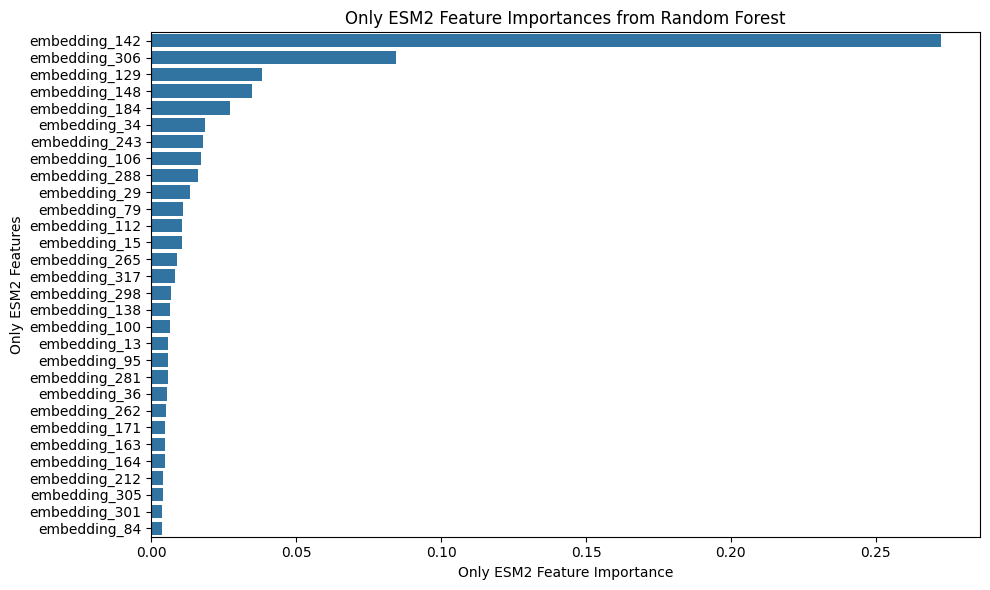

In [60]:
# feature importances
only_embeddings_feature_importances = random_forest_reg_embeddings.named_steps['randomforestregressor'].feature_importances_
only_embeddings_feature_names = X_only_embeddings.columns
only_embeddings_sorted_indices = np.argsort(only_embeddings_feature_importances)[::-1]

top_k = 30

sorted_only_embeddings_feature_importances = only_embeddings_feature_importances[only_embeddings_sorted_indices][:top_k]
sorted_only_embeddings_feature_names = only_embeddings_feature_names[only_embeddings_sorted_indices][:top_k]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_only_embeddings_feature_importances, y=sorted_only_embeddings_feature_names)
plt.xlabel("Only ESM2 Feature Importance")
plt.ylabel("Only ESM2 Features")
plt.title("Only ESM2 Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

In [61]:
# save the model
joblib.dump(random_forest_reg_embeddings, "./models/glucose/random_forest_model_only_embeddings.pkl")

['./models/glucose/random_forest_model_only_embeddings.pkl']

## Activity SCglucose In Silico Directed Evolution

In [62]:
data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

tile_id                                             DNAseq  \
0        0  AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...   
1        1  AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...   
2        2  AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...   
3        3  AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...   
4        4  AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...   

                                      ADseq  numreads_per_AD_7AGFP_AAS  \
0  KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD                        NaN   
1  KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK                      942.0   
2  KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR                        NaN   
3  KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM                      357.0   
4  KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM                      539.0   

   Activity_7AGFP_AAS  numreads_per_AD_8AmCh_AAS  Activity_8AmCh_AAS  \
0                 NaN                        NaN                 NaN   
1          709.606092                      367.0         2921.917252   
2                 NaN                        NaN                 NaN   
3         1039.469842                      342.0         1089.428196   
4         1081.980998                      627.0          622.131501   

   numreads_per_AD_9ARatio_AAS  Activity_9ARatio_AAS  \
0                          NaN                   NaN   
1                        601.0           22242.74698   
2                          NaN                   NaN   
3                        450.0           74251.36241   
4                        586.0           58872.95132   

   numreads_per_AD_10BRatio_AAS  ...  Activity_BYS4_BioRepAverage  \
0                        3151.0  ...                          NaN   
1                        6909.0  ...                  21968.05843   
2                        6577.0  ...                          NaN   
3                           NaN  ...                          NaN   
4                         128.0  ...                  95093.69451   

  Stdev_BYS4_BioReps Activity_SCglucose  Start  Recovered  \
0                NaN        11666.48682    341       True   
1        5849.143385        21968.05843    146       True   
2                NaN        21203.02478    326       True   
3                NaN        47244.41248    246       True   
4       13292.686710        95093.69451    211       True   

   Activity_SCgalactose  Activity_P3promoter  Activity_P14promoter  \
0           97250.68362                  NaN           11149.49032   
1           15516.96245          14570.13217           16872.28649   
2               0.00000          18274.98241           15702.60901   
3           92844.00000                  NaN                   NaN   
4           76399.62949                  NaN          125056.17980   

   Activity_P15promoter  Activity_P3promoterMig1TFBSremoved  
0                   NaN                         8040.343648  
1           11555.08411                        10255.296840  
2           18303.29201                        17265.783330  
3                   NaN                        84807.518160  
4          129302.35080                       100360.735500  

[5 rows x 35 columns]

In [63]:
# Sort by activity
activity = "Activity_SCglucose"
low_activity_df = data.sort_values(by=[activity], ascending=True)
low_activity_df = low_activity_df[['ADseq', activity]].dropna()
low_activity_df


ADseq  Activity_SCglucose
9175   DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN              6138.0
9585   DDKAAGDSAPVDSAPALVKQPSTTPLDSPAPLIMDTYTRR              6138.0
3711   RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV              6138.0
2712   TLAARKSRQRKMQRFEELEDQIAKLEAERDHWKEIALRRS              6138.0
8564   EAARRSRARKMERMNQLEDKVEDLVGEKQALQDEVDRLKS              6138.0
...                                         ...                 ...
6161   HANRGPDFDALFDLTANSFVDGLDAASLAMFDTQQLDKVQ            262143.0
1541   TTFNNTQAQQEFPSIMSTSSIPQDFDALFDLTANSFVDGL            262143.0
11857  GTISPQDLMMDASAPPSASLTDLSTPSFESPGYFSQDPSP            262143.0
6726   PMFEFESLDESNDPKNWTSLFENDLPIITEDDVSLNDKAI            262143.0
6693   PMINTEMDLNAAPEEWESLFPQDGFPLDLDSAALELAVSL            262143.0

[18944 rows x 2 columns]

In [64]:
# Let's look at the min and max values of the activity
low_activity_df.describe()

Activity_SCglucose
count        18944.000000
mean         66087.894674
std          61869.279225
min           6138.000000
25%          24438.359877
50%          43490.494810
75%          77276.723883
max         262143.000000

### In Silico Directed Evolution
Without loss of generality, let's simply pick the protein sequence with the lowest activity and do some a random pointwise mutation. We then repeat this process across $N$ generations. First I will add sequence features so that we can use the random forest model to predict the SCGlucose activity. The reason for this is because the model is very strict with the columns we provide for prediction. It must be named and ordered exactly the same as how we trained the model initially or scikit-learn will complain!

In [65]:
# FEATURES

# variables I need glovally
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

# I use Kyte-Doolittle scale for hydrophobicity hereee CHECK WITH PROF STALLER
# https://www.rbvi.ucsf.edu/chimera/docs/UsersGuide/midas/hydrophob.html
KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

# i use the tuple here for naming the motifs
MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# FUNCTIONS TO CALC

def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    total_hydrophobicity = sum(KD_HYDROPHOBICITY[aa] for aa in sequence if aa in KD_HYDROPHOBICITY)
    return total_hydrophobicity

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# APPLY DA FEATURESSSS
def add_sequence_features(df: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    # AA composition
    aa_expanded = df[seq_col].apply(amino_acid_count).apply(pd.Series)
    
    # Motif counts
    motif_expanded = df[seq_col].apply(motif_counts_dict).apply(pd.Series)

    # Scalar features
    df["NetCharge"] = df[seq_col].apply(net_charge)
    df["Hydrophobicity"] = df[seq_col].apply(hydrophobicity)
    
    # Sequence length
    df["Length"] = df[seq_col].str.len()

    # Combine everything
    result_df = pd.concat([df, aa_expanded, motif_expanded], axis=1)

    return result_df

In [66]:
low_activity_df = add_sequence_features(low_activity_df, seq_col="ADseq")

# now we put activity as the last column for convenience
low_activity_df = low_activity_df[[col for col in low_activity_df.columns if col != activity] + [activity]]
low_activity_df.head()

ADseq  NetCharge  Hydrophobicity  \
9175  DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN          0           -26.6   
9585  DDKAAGDSAPVDSAPALVKQPSTTPLDSPAPLIMDTYTRR         -2           -21.6   
3711  RKLERQDVMERRIAELEKSLEEAEQREQYWKAMAQAQTQV         -1           -53.3   
2712  TLAARKSRQRKMQRFEELEDQIAKLEAERDHWKEIALRRS          3           -54.1   
8564  EAARRSRARKMERMNQLEDKVEDLVGEKQALQDEVDRLKS          0           -54.8   

      Length  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  ...  DE_L  DE_x_WFY  \
9175      40     2     0     2     0     3     1  ...     0         0   
9585      40     6     0     6     0     0     1  ...     0         1   
3711      40     5     0     1     8     0     0  ...     1         1   
2712      40     5     0     2     6     1     0  ...     1         1   
8564      40     4     0     4     6     0     1  ...     1         0   

      DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  Activity_SCglucose  
9175          0   0    0     1         0   1             0              6138.0  
9585          0   0    0     0         0   1             0              6138.0  
3711          1   0    0     0         0   0             0              6138.0  
2712          0   0    0     0         0   0             0              6138.0  
8564          0   0    0     0         0   0             0              6138.0  

[5 rows x 39 columns]

Great! Now what we're going to do is simply take the first row which corresponds to the ADseq with low SCglucose activity. We will also take note of its corresponding activity value for comparison later on!

In [67]:
protein_sequence = low_activity_df.iloc[0, 0]
activity_value = low_activity_df.iloc[0, -1]
print(f"Protein sequence: {protein_sequence}")
print(f"Activity value: {activity_value}")

Protein sequence: DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN
Activity value: 6138.0


Below I define the `simulate_mutations_over_generations` function, an algorithm developed to perform in silico directed evolution. The approach emulates evolutionary pressure by iteratively introducing point mutations to an initial protein sequence over several generations.

In each generation:

1. A large number of mutant sequences are generated by randomly selecting a position in the sequence and replacing the amino acid with another from a defined set.

2. These mutant sequences are evaluated using a custom scoring function that computes relevant features (e.g., biochemical activity, structural properties, or other predictive embeddings).

3. Only mutants that satisfy a minimum disorder threshold—representing a proxy for flexibility or viability—are retained and carried forward as the parental pool for the next generation.

By iterating this process, the algorithm mimics natural selection, gradually evolving the sequence population toward variants with desirable properties in a fully virtual setting.

In [68]:
def simulate_mutations_over_generations(
    initial_sequence: str,
    aa_list: list[str],
    add_features_fn,
    num_generations: int = 10,
    num_mutations_per_generation: int = 1_000,
    max_sequences_per_gen: int = 5_000,
    min_disorder_threshold: float = 0.5
):

    current_sequences = [initial_sequence]
    all_dfs = []

    for gen in tqdm(range(num_generations), desc="Generation"):
        parent_count = len(current_sequences)
        total_events = num_mutations_per_generation

        # Randomly select mutation sites and residues
        parents = np.random.randint(0, parent_count, size=total_events)
        positions = np.random.randint(0, len(initial_sequence), size=total_events)
        new_aas = np.random.choice(aa_list, size=total_events)

        # Create unique mutant sequences
        mutated = {
            current_sequences[p][:pos] + aa + current_sequences[p][pos + 1:]
            for p, pos, aa in zip(parents, positions, new_aas)
        }
        mutated_list = list(mutated)
        tqdm.write(f"Gen {gen+1}: {len(mutated_list)} unique mutants created")

        # Filter mutants by minimum disorder threshold
        filtered_mutants = []
        for seq in tqdm(mutated_list, desc="Filtering by disorder threshold"):
            disorder = np.array(meta.predict_disorder(seq))
            if disorder.mean() >= min_disorder_threshold:
                filtered_mutants.append(seq)

        # Cap total number to max_sequences_per_gen
        mutated_list = filtered_mutants[:max_sequences_per_gen]
        tqdm.write(f"{len(mutated_list)} mutants kept (passed threshold)")

        # Stop early if no viable sequences remain
        if not mutated_list:
            tqdm.write("No viable sequences passed the threshold. Halting.")
            break

        # Add features to the valid sequences
        df = pd.DataFrame({"ADseq": mutated_list})
        df["Generation"] = gen + 1
        df = add_features_fn(df, seq_col="ADseq")

        all_dfs.append(df)
        current_sequences = mutated_list

    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()


In [69]:
result = simulate_mutations_over_generations(
    protein_sequence, 
    list(AA_LIST), 
    add_sequence_features,
    num_generations=5, 
    num_mutations_per_generation=5000
)


Generation:   0%|          | 0/5 [00:00<?, ?it/s]

Gen 1: 758 unique mutants created


Generation:   0%|          | 0/5 [00:02<?, ?it/s]

758 mutants kept (passed threshold)


Generation:  20%|██        | 1/5 [00:03<00:15,  3.86s/it]

Gen 2: 4874 unique mutants created


Generation:  20%|██        | 1/5 [00:18<00:15,  3.86s/it]

4874 mutants kept (passed threshold)


Generation:  40%|████      | 2/5 [00:20<00:34, 11.48s/it]

Gen 3: 4988 unique mutants created


Generation:  40%|████      | 2/5 [00:33<00:34, 11.48s/it]

4988 mutants kept (passed threshold)


Generation:  60%|██████    | 3/5 [00:35<00:26, 13.10s/it]

Gen 4: 4986 unique mutants created


Generation:  60%|██████    | 3/5 [00:49<00:26, 13.10s/it]

4986 mutants kept (passed threshold)


Generation:  80%|████████  | 4/5 [00:51<00:14, 14.09s/it]

Gen 5: 4988 unique mutants created


Generation:  80%|████████  | 4/5 [01:03<00:14, 14.09s/it]

4988 mutants kept (passed threshold)


Generation: 100%|██████████| 5/5 [01:05<00:00, 13.19s/it]


In [70]:
result.head()

ADseq  Generation  NetCharge  \
0  DFVLFDSPQPQRTTVNRPSSVPSNSARPFGSLQSNTTSTN           1          1   
1  DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNFTSTN           1          0   
2  DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQWNTTSTN           1          0   
3  DFVVFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN           1          0   
4  DCVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN           1          0   

   Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_WF  DE_L  \
0           -32.9      40     1     0     2     0     3  ...      1     0   
1           -23.1      40     2     0     2     0     4  ...      1     0   
2           -26.7      40     2     0     2     0     3  ...      1     0   
3           -26.2      40     2     0     2     0     3  ...      1     0   
4           -26.9      40     2     1     2     0     2  ...      0     0   

   DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  
0         0          0   0    0     1         0   1             0  
1         0          0   0    0     1         0   1             0  
2         0          0   0    0     1         0   1             0  
3         0          0   0    0     1         0   1             0  
4         0          0   0    0     0         0   1             0  

[5 rows x 39 columns]

Now that we have our mutated sequences, we will use use our trained model from the activity-predictor notebook where in this case I'm using the random forest model trained only on computed features and not utilizing ESM embeddings since it scored the best in terms of Pearson R^2. We will use the random forest model to predict the activity_SCglucose for our mutated sequences!

In [71]:
model_name = "./models/glucose/random_forest_model.pkl"

# Load the regression model
model = joblib.load(model_name)

mutated_feature = result.drop(columns=["ADseq", "Generation"])

# Make predictions on the mutated sequence
predictions = model.predict(mutated_feature)

# Add predictions to the DataFrame
result[activity] = predictions

result.head()

ADseq  Generation  NetCharge  \
0  DFVLFDSPQPQRTTVNRPSSVPSNSARPFGSLQSNTTSTN           1          1   
1  DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNFTSTN           1          0   
2  DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQWNTTSTN           1          0   
3  DFVVFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN           1          0   
4  DCVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN           1          0   

   Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_L  DE_x_WFY  \
0           -32.9      40     1     0     2     0     3  ...     0         0   
1           -23.1      40     2     0     2     0     4  ...     0         0   
2           -26.7      40     2     0     2     0     3  ...     0         0   
3           -26.2      40     2     0     2     0     3  ...     0         0   
4           -26.9      40     2     1     2     0     2  ...     0         0   

   DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  Activity_SCglucose  
0          0   0    0     1         0   1             0        35702.299049  
1          0   0    0     1         0   1             0        54531.939442  
2          0   0    0     1         0   1             0        53363.892365  
3          0   0    0     1         0   1             0        50937.692851  
4          0   0    0     0         0   1             0        32070.672658  

[5 rows x 40 columns]

Naturally the next thing to do is to find which of these mutations is predicted to have the highest scglucose_activity. We'll then perform a more thorough analysis on this sequence

In [72]:
highest_activity_candidates = result.sort_values(by=[activity], ascending=False)
highest_activity_candidates

ADseq  Generation  NetCharge  \
15809  DFVLFDSPQPVDTTVNHPSSVPSNAAAPFGSLQWNTTSTN           5         -3   
19743  DFVWFDSGQPQRTTVNRPSSVPSNSDADFGSLQSNTTSTN           5         -2   
18265  DFVLFDSPQPQRTTVNRPSSVPSNSFADFGSLYSNYTSFN           5         -1   
14626  DFVYFDSPWPQRTTVNRPSSVPSPSAFPFGSLQSNTTSTN           4          0   
19788  DFVWFDSPQPQRTTVNRPSSVPSNSDADFGSLQSNTTSTN           5         -2   
...                                         ...         ...        ...   
10136  DSVLFDSPQPQRTTSNRPSSVPSNSAAPPGSLQSNTTSTN           3          0   
14513  DIGLAHSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN           4          1   
16870  DEVLGDSPQEQRTTVNRPSSVISNSAAPFGSKQSNTTSTN           5         -1   
5866   DHVLSDSPQPQRTTVNRPSSVPSNSAAPTGSLQSNTTSTN           3          0   
13780  DSVLFDSPQPQRTTSNRPSSVPSNSAAGPGSLQSNTTSTN           4          0   

       Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_L  \
15809           -14.1      40     3     0     3     0     3  ...     0   
19743           -37.3      40     1     0     4     0     3  ...     0   
18265           -22.4      40     1     0     3     0     5  ...     0   
14626           -26.2      40     1     0     2     0     4  ...     0   
19788           -38.5      40     1     0     4     0     3  ...     0   
...               ...     ...   ...   ...   ...   ...   ...  ...   ...   
10136           -39.6      40     2     0     2     0     1  ...     0   
14513           -30.2      40     3     0     1     0     1  ...     0   
16870           -39.6      40     2     0     2     2     1  ...     0   
5866            -39.7      40     2     0     2     0     0  ...     0   
13780           -38.4      40     2     0     2     0     1  ...     0   

       DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  \
15809         0          0   0    0     1         0   1             0   
19743         0          2   0    0     1         0   0             0   
18265         0          0   0    0     2         1   1             0   
14626         0          2   0    1     1         0   2             0   
19788         0          2   0    0     1         0   1             0   
...         ...        ...  ..  ...   ...       ...  ..           ...   
10136         0          0   0    0     0         0   1             0   
14513         0          0   0    0     0         0   1             0   
16870         0          0   0    0     0         0   1             0   
5866          0          0   0    0     0         0   1             0   
13780         0          0   0    0     0         0   1             0   

       Activity_SCglucose  
15809        94109.564776  
19743        93830.419553  
18265        93300.553487  
14626        91151.644733  
19788        90515.406534  
...                   ...  
10136        21442.914883  
14513        21307.805931  
16870        21195.962793  
5866         20953.853288  
13780        20824.619389  

[20594 rows x 40 columns]

Now let's take the top 500 rows based on activity in descending order which will get us the highest activity mutants

In [73]:
top_500 = highest_activity_candidates.head(500)
top_500.head()

ADseq  Generation  NetCharge  \
15809  DFVLFDSPQPVDTTVNHPSSVPSNAAAPFGSLQWNTTSTN           5         -3   
19743  DFVWFDSGQPQRTTVNRPSSVPSNSDADFGSLQSNTTSTN           5         -2   
18265  DFVLFDSPQPQRTTVNRPSSVPSNSFADFGSLYSNYTSFN           5         -1   
14626  DFVYFDSPWPQRTTVNRPSSVPSPSAFPFGSLQSNTTSTN           4          0   
19788  DFVWFDSPQPQRTTVNRPSSVPSNSDADFGSLQSNTTSTN           5         -2   

       Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_L  \
15809           -14.1      40     3     0     3     0     3  ...     0   
19743           -37.3      40     1     0     4     0     3  ...     0   
18265           -22.4      40     1     0     3     0     5  ...     0   
14626           -26.2      40     1     0     2     0     4  ...     0   
19788           -38.5      40     1     0     4     0     3  ...     0   

       DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  \
15809         0          0   0    0     1         0   1             0   
19743         0          2   0    0     1         0   0             0   
18265         0          0   0    0     2         1   1             0   
14626         0          2   0    1     1         0   2             0   
19788         0          2   0    0     1         0   1             0   

       Activity_SCglucose  
15809        94109.564776  
19743        93830.419553  
18265        93300.553487  
14626        91151.644733  
19788        90515.406534  

[5 rows x 40 columns]

### Cross-Examination Between Original and Mutated Sequences\

In [74]:
top_candidate = top_500.iloc[0]
print(f"Top candidate sequence: {top_candidate['ADseq']}")
print(f"Original sequence: {protein_sequence}")
print(f"Original activity: {activity_value}")
print(f"Predicted activity: {top_candidate[activity]}")

Top candidate sequence: DFVLFDSPQPVDTTVNHPSSVPSNAAAPFGSLQWNTTSTN
Original sequence: DFVLFDSPQPQRTTVNRPSSVPSNSAAPFGSLQSNTTSTN
Original activity: 6138.0
Predicted activity: 94109.5647757


In [75]:
# i wanna see how these two are different
def compare_sequences(seq1: str, seq2: str) -> list[tuple[int, str, str]]:
    differences = []
    for i, (a, b) in enumerate(zip(seq1, seq2)):
        if a != b:
            differences.append((i, a, b))
    return differences
differences = compare_sequences(protein_sequence, top_candidate["ADseq"])
print("Differences between original and top candidate:")
for pos, original_aa, new_aa in differences:
    print(f"Position {pos}: {original_aa} -> {new_aa}")

Differences between original and top candidate:
Position 10: Q -> V
Position 11: R -> D
Position 16: R -> H
Position 24: S -> A
Position 33: S -> W


In [76]:
# Let's check the difference in net charge and hydrophobicity
original_net_charge = net_charge(protein_sequence)
top_candidate_net_charge = net_charge(top_candidate["ADseq"])
print(f"Original net charge: {original_net_charge}")
print(f"Top candidate net charge: {top_candidate_net_charge}")
print(f"Net charge difference: {top_candidate_net_charge - original_net_charge}")


original_hydrophobicity = hydrophobicity(protein_sequence)
top_candidate_hydrophobicity = hydrophobicity(top_candidate["ADseq"])
print(f"Original hydrophobicity: {original_hydrophobicity}")
print(f"Top candidate hydrophobicity: {top_candidate_hydrophobicity}")
print(f"Hydrophobicity difference: {top_candidate_hydrophobicity - original_hydrophobicity}")

Original net charge: 0
Top candidate net charge: -3
Net charge difference: -3
Original hydrophobicity: -26.599999999999998
Top candidate hydrophobicity: -14.100000000000001
Hydrophobicity difference: 12.499999999999996


### Disorder Analysis with Meta Predict

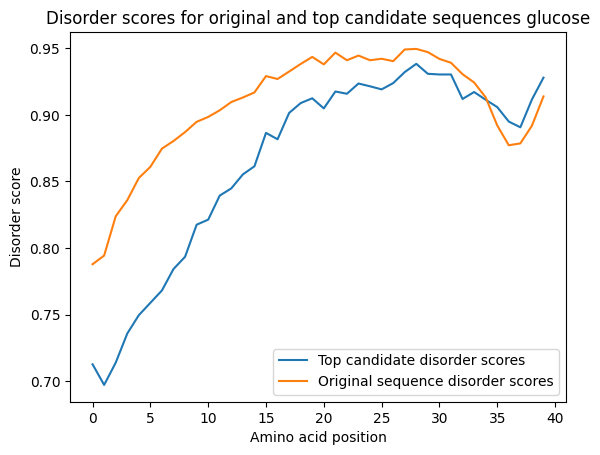

In [77]:
top_candidate_disorder_scores = meta.predict_disorder(top_candidate["ADseq"])
original_sequence_disorder_scores = meta.predict_disorder(protein_sequence)

plt.plot(top_candidate_disorder_scores, label="Top candidate disorder scores")
plt.plot(original_sequence_disorder_scores, label="Original sequence disorder scores")
plt.xlabel("Amino acid position")
plt.ylabel("Disorder score")
plt.title("Disorder scores for original and top candidate sequences glucose")
plt.legend()
plt.show()


I believe what we can tell from this is that our top candidate here is likely to maintain the intrinsically disordered structure characteristic of functional activation domains. The plot above shows that the improved predicted activity did not come at the cost of order-disorder balance which is a good things and it might even hint at the possibility that slight modulation in specific regions could be beneficial

### Save Top 500 Sequences To CSV

In [81]:
# Save the top 500 sequences to a CSV file
top_500.to_csv(f"./mutants/glucose/top_500_sequences_{activity}.csv", index=False)

## Activity SCgalactose Analysis and Model Development
For this section we give credit to Jasleen and Skye for collaborating on getting results for this activity column

In [83]:
#Start off by importing the data

data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

tile_id                                             DNAseq  \
0        0  AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...   
1        1  AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...   
2        2  AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...   
3        3  AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...   
4        4  AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...   

                                      ADseq  numreads_per_AD_7AGFP_AAS  \
0  KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD                        NaN   
1  KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK                      942.0   
2  KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR                        NaN   
3  KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM                      357.0   
4  KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM                      539.0   

   Activity_7AGFP_AAS  numreads_per_AD_8AmCh_AAS  Activity_8AmCh_AAS  \
0                 NaN                        NaN                 NaN   
1          709.606092                      367.0         2921.917252   
2                 NaN                        NaN                 NaN   
3         1039.469842                      342.0         1089.428196   
4         1081.980998                      627.0          622.131501   

   numreads_per_AD_9ARatio_AAS  Activity_9ARatio_AAS  \
0                          NaN                   NaN   
1                        601.0           22242.74698   
2                          NaN                   NaN   
3                        450.0           74251.36241   
4                        586.0           58872.95132   

   numreads_per_AD_10BRatio_AAS  ...  Activity_BYS4_BioRepAverage  \
0                        3151.0  ...                          NaN   
1                        6909.0  ...                  21968.05843   
2                        6577.0  ...                          NaN   
3                           NaN  ...                          NaN   
4                         128.0  ...                  95093.69451   

  Stdev_BYS4_BioReps Activity_SCglucose  Start  Recovered  \
0                NaN        11666.48682    341       True   
1        5849.143385        21968.05843    146       True   
2                NaN        21203.02478    326       True   
3                NaN        47244.41248    246       True   
4       13292.686710        95093.69451    211       True   

   Activity_SCgalactose  Activity_P3promoter  Activity_P14promoter  \
0           97250.68362                  NaN           11149.49032   
1           15516.96245          14570.13217           16872.28649   
2               0.00000          18274.98241           15702.60901   
3           92844.00000                  NaN                   NaN   
4           76399.62949                  NaN          125056.17980   

   Activity_P15promoter  Activity_P3promoterMig1TFBSremoved  
0                   NaN                         8040.343648  
1           11555.08411                        10255.296840  
2           18303.29201                        17265.783330  
3                   NaN                        84807.518160  
4          129302.35080                       100360.735500  

[5 rows x 35 columns]

In [84]:
num_rows = data.shape[0]
num_cols = data.shape[1]

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 19038
Number of columns: 35


In [85]:
read_threshold = 1000 # threshold for read count

df_gal = data[(data['TotalReads_BioRepA_BYS4'] >= read_threshold) & (data['TotalReads_BioRepB_BYS4'] >= read_threshold)]
print(f"Number of rows before filtering: {num_rows}")
print(f"Number of rows removed: {num_rows - df_gal.shape[0]}")
print(f"Number of rows after filtering: {df_gal.shape[0]}")

Number of rows before filtering: 19038
Number of rows removed: 9985
Number of rows after filtering: 9053


In [86]:

activity_col_gal = "Activity_SCgalactose"
df_gal = df_gal[df_gal[activity_col_gal] > 0]

print(f"Number of rows after filtering for non-zero {activity_col_gal}: {df_gal.shape[0]}")

Number of rows after filtering for non-zero Activity_SCgalactose: 8360


In [87]:
# Check for duplicates
duplicates_gal = df_gal.duplicated(subset=["tile_id"], keep=False)
print(f"Number of duplicate rows: {duplicates_gal.sum()}")

Number of duplicate rows: 0


In [88]:
df_with_seq_gal = df_gal.copy()

In [89]:
# Global constants reused for galactose
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# Feature extraction functions
def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    return sum(KD_HYDROPHOBICITY.get(aa, 0) for aa in sequence)

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# Galactose-specific application
def add_sequence_features_gal(df_gal: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    df_gal = df_gal.copy()

    # Basic features
    aa_expanded = df_gal[seq_col].apply(amino_acid_count).apply(pd.Series)
    motif_expanded = df_gal[seq_col].apply(motif_counts_dict).apply(pd.Series)

    df_gal["NetCharge"] = df_gal[seq_col].apply(net_charge)
    df_gal["Hydrophobicity"] = df_gal[seq_col].apply(hydrophobicity)
    df_gal["Length"] = df_gal[seq_col].str.len()

    # Combine into one dataframe
    result_df_gal = pd.concat([df_gal, aa_expanded, motif_expanded], axis=1)
    return result_df_gal



In [90]:
# Apply features to the filtered DataFrame
df_gal = add_sequence_features_gal(df_gal)
df_gal.iloc[:, 35:]

NetCharge  Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  \
1              6           -34.0      40     2     0     2     0     0     4   
7              1           -24.2      40     3     1     2     1     1     3   
8              2           -36.7      40     2     0     3     0     0     2   
12            -4           -13.8      40     6     0     4     2     4     3   
18             6           -24.4      40     5     0     0     1     2     0   
...          ...             ...     ...   ...   ...   ...   ...   ...   ...   
19021         -1           -33.9      40     2     0     3     1     4     0   
19030         -6            19.9      40     3     1     6     0     3     1   
19033         -7           -42.3      40     1     0     5     3     2     2   
19036          2            27.8      40     5     2     1     0     2     3   
19037         -4           -14.4      40     1     0     4     1     4     2   

       AA_H  ...  DE_WF  DE_L  DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  \
1         1  ...      0     0         0          0   0    0     0         0   
7         3  ...      0     0         0          0   0    0     0         0   
8         1  ...      0     0         1          0   0    0     0         0   
12        0  ...      1     3         0          1   0    0     1         0   
18        1  ...      0     0         0          0   0    0     0         0   
...     ...  ...    ...   ...       ...        ...  ..  ...   ...       ...   
19021     4  ...      1     0         0          1   0    0     1         0   
19030     0  ...      0     1         0          1   0    0     0         0   
19033     1  ...      0     1         1          1   0    0     0         0   
19036     2  ...      0     0         0          0   0    0     0         0   
19037     2  ...      0     2         0          0   0    0     0         1   

       SP  WFYL_3x_WFYL  
1       1             0  
7       0             0  
8       2             0  
12      1             0  
18      1             0  
...    ..           ...  
19021   1             0  
19030   0             0  
19033   1             0  
19036   1             0  
19037   1             0  

[8360 rows x 37 columns]

In [91]:
x_gal = df_gal.iloc[:, 35:]
y_gal = df_gal[activity_col_gal]


# now i structure the final prep data
df = pd.concat([x_gal, y_gal], axis=1)

assert df.isna().sum().sum() == 0, "Features contain NaNs"

# quick sanity check for missing values
print("Missing values in final data:")
print(df.isnull().sum())

Missing values in final data:
NetCharge               0
Hydrophobicity          0
Length                  0
AA_A                    0
AA_C                    0
AA_D                    0
AA_E                    0
AA_F                    0
AA_G                    0
AA_H                    0
AA_I                    0
AA_K                    0
AA_L                    0
AA_M                    0
AA_N                    0
AA_P                    0
AA_Q                    0
AA_R                    0
AA_S                    0
AA_T                    0
AA_V                    0
AA_W                    0
AA_Y                    0
W..LF                   0
WFYL_WFYL               0
WFL_WFL                 0
DE_WFY                  0
DE_WF                   0
DE_L                    0
DE_x_WFY                0
DE_xx_WFY               0
FF                      0
F_F                     0
F__F                    0
FY_5x_FY                0
SP                      0
WFYL_3x_WFYL            0
Activity

In [92]:
df.head()

NetCharge  Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  \
1           6           -34.0      40     2     0     2     0     0     4   
7           1           -24.2      40     3     1     2     1     1     3   
8           2           -36.7      40     2     0     3     0     0     2   
12         -4           -13.8      40     6     0     4     2     4     3   
18          6           -24.4      40     5     0     0     1     2     0   

    AA_H  ...  DE_L  DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  \
1      1  ...     0         0          0   0    0     0         0   1   
7      3  ...     0         0          0   0    0     0         0   0   
8      1  ...     0         1          0   0    0     0         0   2   
12     0  ...     3         0          1   0    0     1         0   1   
18     1  ...     0         0          0   0    0     0         0   1   

    WFYL_3x_WFYL  Activity_SCgalactose  
1              0           15516.96245  
7              0          150640.30040  
8              0           87627.61586  
12             0          143327.09160  
18             0           11900.55917  

[5 rows x 38 columns]

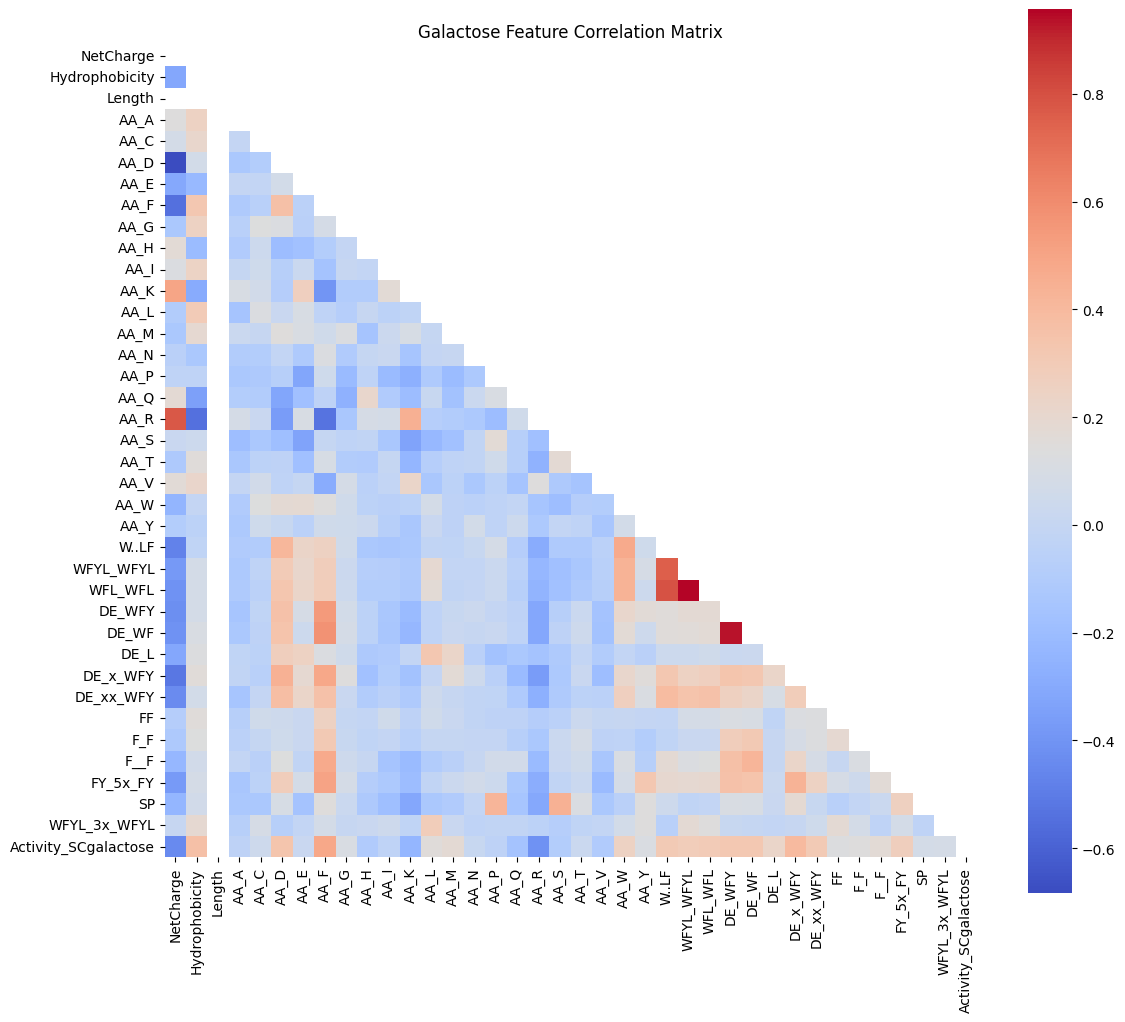

In [93]:

# Check correlation matrix
plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=False, fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Galactose Feature Correlation Matrix")
plt.tight_layout()
#plt.savefig("GCN4_correlation_matrix.png")
plt.show()


In [94]:
# Get top 10 positive and negative correlations with the target variable
corr_target = df.corr()[activity_col_gal].sort_values(ascending=False)
top_10_positive = corr_target.head(10)
top_10_negative = corr_target.tail(10)
print("Top 10 positive correlations with target:")
print(top_10_positive)

print("="*50)

print("Top 10 negative correlations with target:")
print(top_10_negative)

Top 10 positive correlations with target:
Activity_SCgalactose    1.000000
AA_F                    0.483265
DE_x_WFY                0.398081
Hydrophobicity          0.363599
AA_D                    0.338413
DE_WFY                  0.320236
DE_WF                   0.318454
W..LF                   0.309696
DE_xx_WFY               0.307296
WFL_WFL                 0.297927
Name: Activity_SCgalactose, dtype: float64
Top 10 negative correlations with target:
AA_P        -0.036554
AA_A        -0.041080
AA_S        -0.089480
AA_V        -0.102987
AA_H        -0.106469
AA_Q        -0.160848
AA_K        -0.237128
AA_R        -0.408354
NetCharge   -0.445969
Length            NaN
Name: Activity_SCgalactose, dtype: float64


In [95]:
x_train_gal, x_test_gal, y_train_gal, y_test_gal = train_test_split(x_gal, y_gal, test_size=0.2, random_state=42)

In [96]:
linear_reg_gal = make_pipeline(StandardScaler(), LinearRegression())
linear_reg_gal.fit(x_train_gal, y_train_gal)
linear_reg_y_pred_gal = linear_reg_gal.predict(x_test_gal)

print("Linear Regression Results:")
print(f"R^2: {r2_score(y_test_gal, linear_reg_y_pred_gal):.4f}")
print(f"MAE: {mean_absolute_error(y_test_gal, linear_reg_y_pred_gal):.4f}")
print(f"RMSE: {root_mean_squared_error(y_test_gal, linear_reg_y_pred_gal):.4f}")
print(f"Pearson Correlation: {pearsonr(y_test_gal, linear_reg_y_pred_gal)[0]:.4f}")

Linear Regression Results:
R^2: 0.3900
MAE: 32843.5278
RMSE: 42034.3877
Pearson Correlation: 0.6252


In [97]:
ridge_reg_gal = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg_gal.fit(x_train_gal, y_train_gal)
ridge_reg_y_pred_gal = ridge_reg_gal.predict(x_test_gal)
print("Ridge Regression Results for SCgalactose:")
print(f"R^2: {r2_score(y_test_gal, ridge_reg_y_pred_gal):.3f}")
print(f"MAE: {mean_absolute_error(y_test_gal, ridge_reg_y_pred_gal):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test_gal, ridge_reg_y_pred_gal):.3f}")
print(f"Pearson Correlation: {pearsonr(y_test_gal, ridge_reg_y_pred_gal)[0]:.3f}")

Ridge Regression Results for SCgalactose:
R^2: 0.390
MAE: 32844.087
RMSE: 42034.659
Pearson Correlation: 0.625


In [98]:
lasso_reg_gal = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg_gal.fit(x_train_gal, y_train_gal)
lasso_reg_y_pred_gal = lasso_reg_gal.predict(x_test_gal)

print("Lasso Regression Results:")
print(f"R^2: {r2_score(y_test_gal, lasso_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_test_gal, lasso_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_test_gal, lasso_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_test_gal, lasso_reg_y_pred_gal)[0]}")

Lasso Regression Results:
R^2: 0.39002079335234063
MAE: 32843.99240486016
RMSE: 42034.388873136224
Pearson Correlation: 0.6252302898619648


In [99]:
grad_boost_reg_gal = make_pipeline(
    StandardScaler(),
    GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
)
grad_boost_reg_gal.fit(x_train_gal, y_train_gal)
grad_boost_reg_y_pred_gal = grad_boost_reg_gal.predict(x_test_gal)
print("Gradient Boosting Regressor Results for SCgalactose:")
print(f"R^2: {r2_score(y_test_gal, grad_boost_reg_y_pred_gal):.3f}")
print(f"MAE: {mean_absolute_error(y_test_gal, grad_boost_reg_y_pred_gal):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test_gal, grad_boost_reg_y_pred_gal):.3f}")
print(f"Pearson Correlation: {pearsonr(y_test_gal, grad_boost_reg_y_pred_gal)[0]:.3f}")

Gradient Boosting Regressor Results for SCgalactose:
R^2: 0.408
MAE: 32322.851
RMSE: 41409.985
Pearson Correlation: 0.639


In [100]:
elastic_reg_gal = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000))
elastic_reg_gal.fit(x_train_gal, y_train_gal)
elastic_reg_y_pred_gal = elastic_reg_gal.predict(x_test_gal)

print("Elastic Net Regression Results:")
print(f"R^2: {r2_score(y_test_gal, elastic_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_test_gal, elastic_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_test_gal, elastic_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_test_gal, elastic_reg_y_pred_gal)[0]}")

Elastic Net Regression Results:
R^2: 0.37084742609639665
MAE: 34093.24945767738
RMSE: 42689.9072424606
Pearson Correlation: 0.6131014048525667


In [101]:
random_forest_reg_gal = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=100, random_state=42)
)
random_forest_reg_gal.fit(x_train_gal, y_train_gal)
random_forest_y_pred_gal = random_forest_reg_gal.predict(x_test_gal)

print("Random Forest Regressor Results for SCgalactose:")
print(f"R^2: {r2_score(y_test_gal, random_forest_y_pred_gal):.3f}")
print(f"MAE: {mean_absolute_error(y_test_gal, random_forest_y_pred_gal):.3f}")
print(f"RMSE: {root_mean_squared_error(y_test_gal, random_forest_y_pred_gal):.3f}")
print(f"Pearson Correlation: {pearsonr(y_test_gal, random_forest_y_pred_gal)[0]:.3f}")

Random Forest Regressor Results for SCgalactose:
R^2: 0.429
MAE: 31196.194
RMSE: 40673.917
Pearson Correlation: 0.655


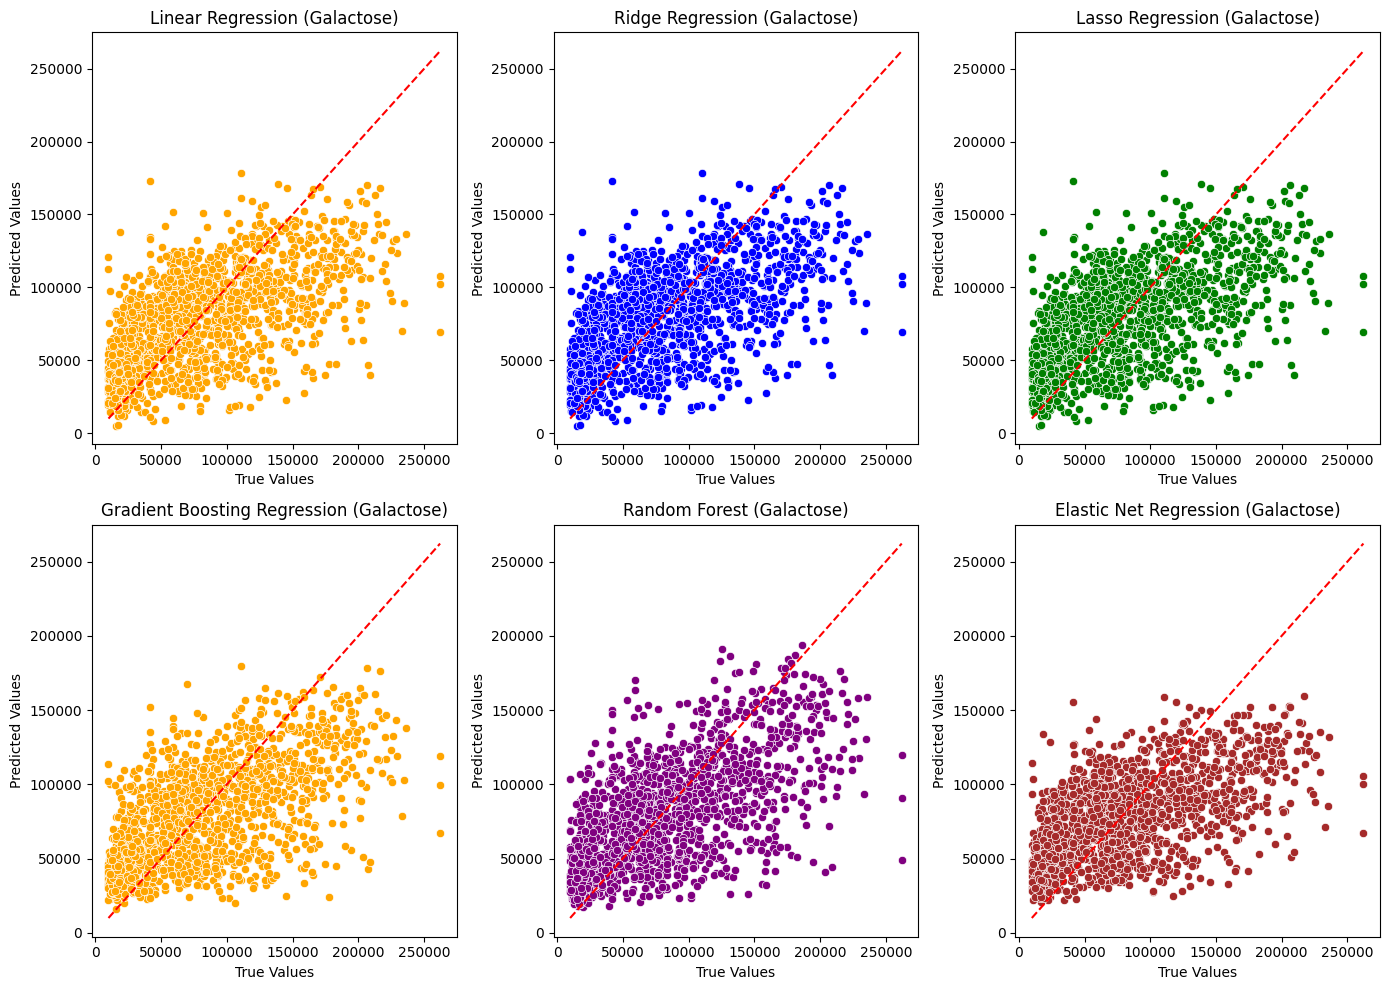

In [102]:
# Make subplots for each model on SCgalactose
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

# Ridge Regression
sns.scatterplot(x=y_test_gal, y=ridge_reg_y_pred_gal, ax=axes[1], color='blue')
axes[1].set_title("Ridge Regression (Galactose)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_test_gal, y=y_test_gal, ax=axes[1], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_test_gal, y=lasso_reg_y_pred_gal , ax=axes[2], color='green')
axes[2].set_title("Lasso Regression (Galactose)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_test_gal, y=y_test_gal, ax=axes[2], color='red', linestyle='--')

# Gradient 
sns.scatterplot(x=y_test_gal, y=grad_boost_reg_y_pred_gal, ax=axes[3], color='orange')
axes[3].set_title("Gradient Boosting Regression (Galactose)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_test_gal, y=y_test_gal, ax=axes[3], color='red', linestyle='--')

# Linear Regression
sns.scatterplot(x=y_test_gal, y=linear_reg_y_pred_gal, ax=axes[0], color='orange')
axes[0].set_title("Linear Regression (Galactose)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_test_gal, y=y_test_gal, ax=axes[0], color='red', linestyle='--')

# Random Forest
sns.scatterplot(x=y_test_gal, y=random_forest_y_pred_gal, ax=axes[4], color='purple')
axes[4].set_title("Random Forest (Galactose)")
axes[4].set_xlabel("True Values")
axes[4].set_ylabel("Predicted Values")
sns.lineplot(x=y_test_gal, y=y_test_gal, ax=axes[4], color='red', linestyle='--')

# Elastic Net Regression
sns.scatterplot(x=y_test_gal, y=elastic_reg_y_pred_gal, ax=axes[5], color='brown')
axes[5].set_title("Elastic Net Regression (Galactose)")
axes[5].set_xlabel("True Values")
axes[5].set_ylabel("Predicted Values")
sns.lineplot(x=y_test_gal, y=y_test_gal, ax=axes[5], color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [103]:
# Make df of results
results = {
    "Model": ["Linear (for Galactose)", "Ridge (for Galactose)", "Lasso (for Galactose)", "Gradient Boosting (for Galactose)", "Random Forest (for Galactose)", "Elastic Net (for Galactose)"],
    "R^2": [
        r2_score(y_test_gal, linear_reg_y_pred_gal),
        r2_score(y_test_gal, ridge_reg_y_pred_gal),
        r2_score(y_test_gal, lasso_reg_y_pred_gal),
        r2_score(y_test_gal, grad_boost_reg_y_pred_gal),
        r2_score(y_test_gal, random_forest_y_pred_gal),
        r2_score(y_test_gal, elastic_reg_y_pred_gal)
    ],
    "MAE": [
        mean_absolute_error(y_test_gal, linear_reg_y_pred_gal),
        mean_absolute_error(y_test_gal, ridge_reg_y_pred_gal),
        mean_absolute_error(y_test_gal, lasso_reg_y_pred_gal),
        mean_absolute_error(y_test_gal, grad_boost_reg_y_pred_gal),
        mean_absolute_error(y_test_gal, random_forest_y_pred_gal),
        mean_absolute_error(y_test_gal, elastic_reg_y_pred_gal)
    ],
    "RMSE": [
        root_mean_squared_error(y_test_gal, linear_reg_y_pred_gal),
        root_mean_squared_error(y_test_gal, ridge_reg_y_pred_gal),
        root_mean_squared_error(y_test_gal, lasso_reg_y_pred_gal),
        root_mean_squared_error(y_test_gal, grad_boost_reg_y_pred_gal),
        root_mean_squared_error(y_test_gal, random_forest_y_pred_gal),
        root_mean_squared_error(y_test_gal, elastic_reg_y_pred_gal)
    ],
    "Pearson Correlation": [
        pearsonr(y_test_gal, linear_reg_y_pred_gal)[0],
        pearsonr(y_test_gal, ridge_reg_y_pred_gal)[0],
        pearsonr(y_test_gal, lasso_reg_y_pred_gal)[0],
        pearsonr(y_test_gal, grad_boost_reg_y_pred_gal)[0],
        pearsonr(y_test_gal, random_forest_y_pred_gal)[0],
        pearsonr(y_test_gal, elastic_reg_y_pred_gal)[0]
    ]
}
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="R^2", ascending=False).reset_index(drop=True)   
results_df.head(6)

Model       R^2           MAE          RMSE  \
0      Random Forest (for Galactose)  0.428867  31196.193562  40673.917323   
1  Gradient Boosting (for Galactose)  0.408008  32322.850579  41409.985053   
2             Linear (for Galactose)  0.390021  32843.527846  42034.387693   
3              Lasso (for Galactose)  0.390021  32843.992405  42034.388873   
4              Ridge (for Galactose)  0.390013  32844.087143  42034.659486   
5        Elastic Net (for Galactose)  0.370847  34093.249458  42689.907242   

   Pearson Correlation  
0             0.655263  
1             0.639404  
2             0.625230  
3             0.625230  
4             0.625224  
5             0.613101

In [104]:
# Save the model
joblib.dump(random_forest_reg_gal, "./models/galactose/random_forest_gal_model.pkl")

['./models/galactose/random_forest_gal_model.pkl']

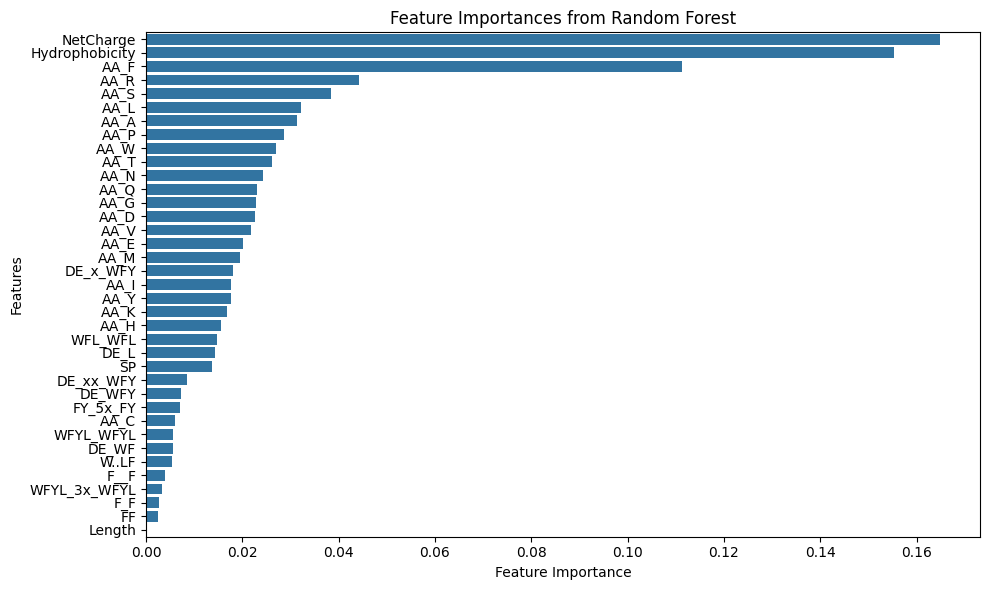

In [105]:

feature_importances = random_forest_reg_gal.named_steps['randomforestregressor'].feature_importances_
feature_names = x_gal.columns
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

In [106]:
# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the embeddings
    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

# Comment out when not needed
save_embeddings_to_npz(df_with_seq_gal, sequence_column="ADseq", save_path="./feature-embeddings/galactose_esm2_embeddings.npz")

/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 8360/8360 [03:08<00:00, 44.25it/s] 


Saved 8360 embeddings to ./feature-embeddings/galactose_esm2_embeddings.npz


In [107]:
# Load the embeddings from the NPZ file
embeddings_data = np.load("./feature-embeddings/galactose_esm2_embeddings.npz")
embeddings_gal = embeddings_data["embeddings"]

# Check the shape of the loaded embeddings
print(f"Loaded embeddings shape: {embeddings_gal.shape}")

Loaded embeddings shape: (8360, 320)


In [108]:
# Prep embededings into a dataframe for feature concatenation
embeddings_df_gal = pd.DataFrame(embeddings_gal)
embeddings_df_gal.columns = [f"embedding_{i}" for i in range(embeddings_df_gal.shape[1])]
embeddings_df_gal.head(3)

embedding_0  embedding_1  embedding_2  embedding_3  embedding_4  \
0    -0.025192    -0.386163     0.038171     0.142583     0.045324   
1     0.014334    -0.416917     0.232792     0.121774    -0.028585   
2    -0.005063    -0.397236    -0.005174     0.114196     0.172707   

   embedding_5  embedding_6  embedding_7  embedding_8  embedding_9  ...  \
0    -0.185973    -0.089887     0.023278    -0.155760    -0.039424  ...   
1    -0.204531    -0.152476     0.021117    -0.132263    -0.106221  ...   
2    -0.098770    -0.020182     0.004256    -0.168792    -0.136290  ...   

   embedding_310  embedding_311  embedding_312  embedding_313  embedding_314  \
0       0.242718      -0.096438       0.113960       0.213151      -0.079959   
1       0.087891      -0.152725       0.103766       0.121723      -0.077505   
2       0.192599      -0.115246       0.148075       0.255852      -0.075508   

   embedding_315  embedding_316  embedding_317  embedding_318  embedding_319  
0       0.146884      -0.072922       0.234120      -0.032808       0.050551  
1       0.077167      -0.150012       0.081626       0.134874       0.011173  
2       0.183582      -0.043454       0.221282       0.090849       0.028793  

[3 rows x 320 columns]

In [109]:
# the assert below is for me to chek for dimension mismatch
assert embeddings_df_gal.shape[0] == df_gal.shape[0], "Mismatch in number of rows between embeddings and original DataFrame"

# Concatenate the embeddings with the original DataFrame
x_esm_gal = pd.concat([x_gal.reset_index(drop=True),
                   embeddings_df_gal.reset_index(drop=True)],
                  axis=1)
y_esm_gal = y_gal.copy()

print(f"X_esm shape: {x_esm_gal.shape}")
print(f"y_esm shape: {y_esm_gal.shape}")

X_esm shape: (8360, 357)
y_esm shape: (8360,)


In [110]:
x_esm_train_gal, x_esm_test_gal, y_esm_train_gal, y_esm_test_gal = train_test_split(x_esm_gal, y_esm_gal, test_size=0.2, random_state=42)

In [111]:
esm_linear_reg_gal = make_pipeline(StandardScaler(), LinearRegression())
esm_linear_reg_gal.fit(x_esm_train_gal, y_esm_train_gal)
esm_linear_reg_y_pred_gal = esm_linear_reg_gal.predict(x_esm_test_gal)

print("Linear Regression with ESM Embeddings Results:")
print(f"R^2: {r2_score(y_esm_test_gal, esm_linear_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_esm_test_gal, esm_linear_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test_gal, esm_linear_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test_gal, esm_linear_reg_y_pred_gal)[0]}")

Linear Regression with ESM Embeddings Results:
R^2: 0.3731052254383064
MAE: 32416.201036401726
RMSE: 42613.23913613073
Pearson Correlation: 0.6237235552660194


In [112]:
esm_ridge_reg_gal = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
esm_ridge_reg_gal.fit(x_esm_train_gal, y_esm_train_gal)
esm_ridge_reg_y_pred_gal = esm_ridge_reg_gal.predict(x_esm_test_gal)

# Just print for now
print("Ridge Regression Results (Galactose):")
print(f"R^2: {r2_score(y_esm_test_gal, esm_ridge_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_esm_test_gal, esm_ridge_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test_gal, esm_ridge_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test_gal, esm_ridge_reg_y_pred_gal)[0]}")

Ridge Regression Results (Galactose):
R^2: 0.41822596806640433
MAE: 31288.159035867553
RMSE: 41051.0611983017
Pearson Correlation: 0.6510301314947882


In [113]:
# Lasso Regression
esm_lasso_reg_gal = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
esm_lasso_reg_gal.fit(x_esm_train_gal, y_esm_train_gal)
esm_lasso_reg_y_pred_gal = esm_lasso_reg_gal.predict(x_esm_test_gal)

print("Lasso Regression Results (Galactose):")
print(f"R^2: {r2_score(y_esm_test_gal, esm_lasso_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_esm_test_gal, esm_lasso_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test_gal, esm_lasso_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test_gal, esm_lasso_reg_y_pred_gal)[0]}")

Lasso Regression Results (Galactose):
R^2: 0.417984829866202
MAE: 31299.849988815764
RMSE: 41059.56789757981
Pearson Correlation: 0.6509566113211686


/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.921e+12, tolerance: 2.000e+09
  model = cd_fast.enet_coordinate_descent(


In [114]:
# Gradient Boosting Regression
esm_grad_boost_reg_gal = GradientBoostingRegressor(n_estimators=100, random_state=42)
esm_grad_boost_reg_gal.fit(x_esm_train_gal, y_esm_train_gal)
esm_grad_boost_reg_y_pred_gal = esm_grad_boost_reg_gal.predict(x_esm_test_gal)

print("Gradient Boosting Regression Results (Galactose):")
print(f"R^2: {r2_score(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal)[0]}")

Gradient Boosting Regression Results (Galactose):
R^2: 0.4198202654636941
MAE: 31705.486289060555
RMSE: 40994.77431006737
Pearson Correlation: 0.6486221160278969


In [115]:
esm_elastic_reg_gal = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000))
esm_elastic_reg_gal.fit(x_esm_train_gal, y_esm_train_gal)
esm_elastic_reg_y_pred_gal = esm_elastic_reg_gal.predict(x_esm_test_gal)

print("Elastic Net Regression Results:")
print(f"R^2: {r2_score(y_esm_test_gal, esm_elastic_reg_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_esm_test_gal, esm_elastic_reg_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test_gal, esm_elastic_reg_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test_gal, esm_elastic_reg_y_pred_gal)[0]}")

Elastic Net Regression Results:
R^2: 0.4071577827145081
MAE: 32442.134444274318
RMSE: 41439.71727818723
Pearson Correlation: 0.639422278751472


In [116]:
# Random Forest Regression
esm_random_forest_reg_gal = RandomForestRegressor(n_estimators=100, random_state=42)
esm_random_forest_reg_gal.fit(x_esm_train_gal, y_esm_train_gal)
esm_random_forest_y_pred_gal = esm_random_forest_reg_gal.predict(x_esm_test_gal)

print("Random Forest Regression Results (Galactose):")
print(f"R^2: {r2_score(y_esm_test_gal, esm_random_forest_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_esm_test_gal, esm_random_forest_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_esm_test_gal, esm_random_forest_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_esm_test_gal, esm_random_forest_y_pred_gal)[0]}")

Random Forest Regression Results (Galactose):
R^2: 0.4324232752008783
MAE: 31491.56080993609
RMSE: 40547.07320195622
Pearson Correlation: 0.6586922813149778


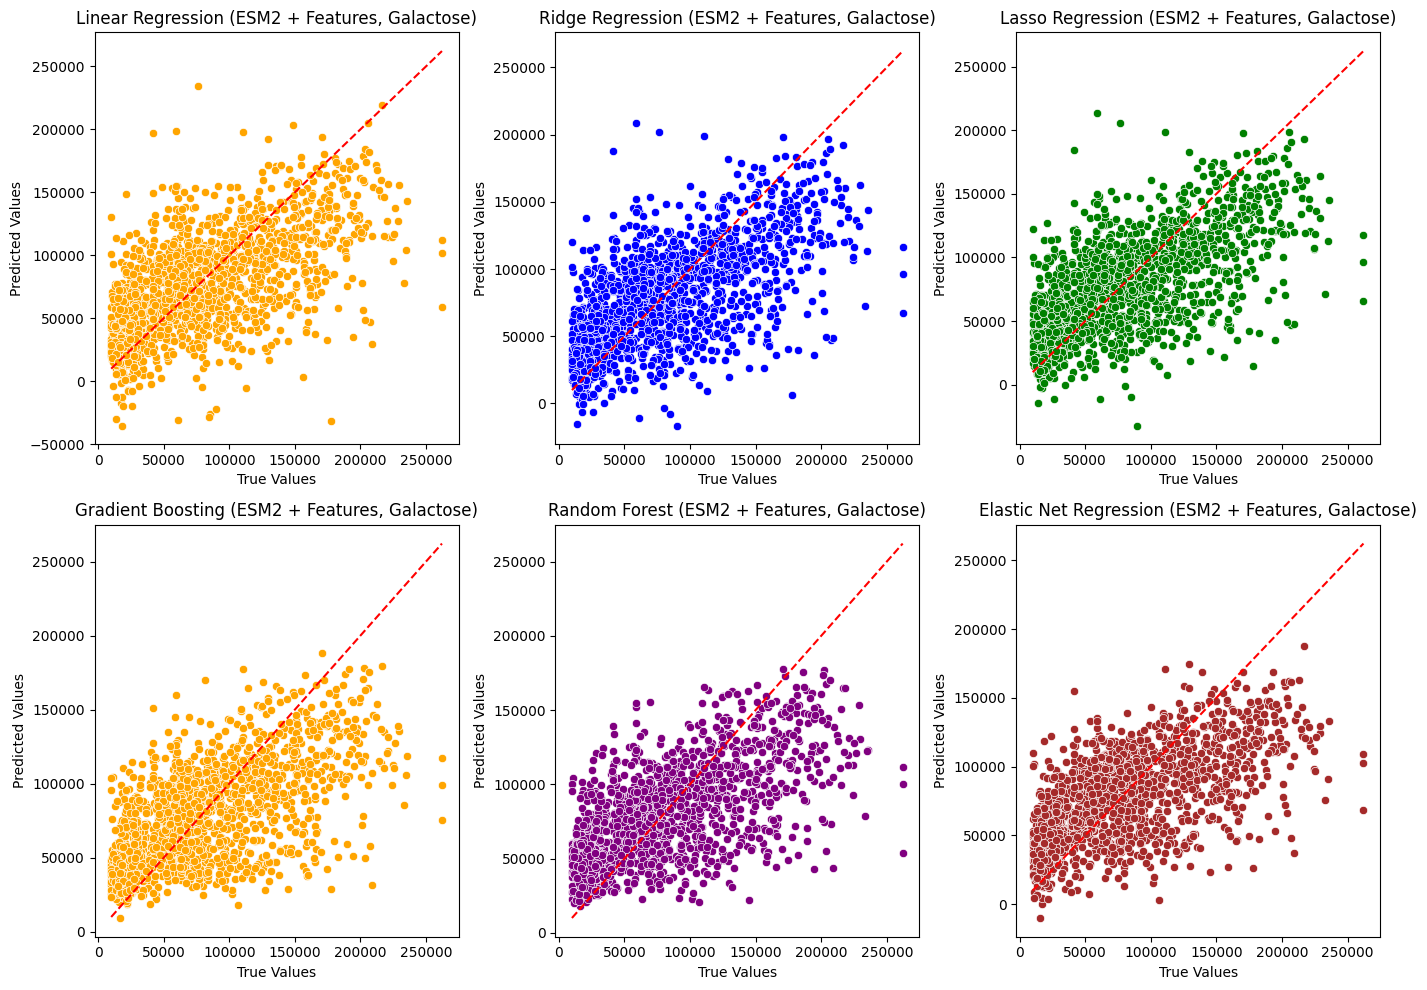

In [117]:
# Make subplots for each model (Galactose)
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

# Linear Regression
sns.scatterplot(x=y_esm_test_gal, y=esm_linear_reg_y_pred_gal, ax=axes[0], color='orange')
axes[0].set_title("Linear Regression (ESM2 + Features, Galactose)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test_gal, y=y_esm_test_gal, ax=axes[0], color='red', linestyle='--')

# Ridge Regression
sns.scatterplot(x=y_esm_test_gal, y=esm_ridge_reg_y_pred_gal, ax=axes[1], color='blue')
axes[1].set_title("Ridge Regression (ESM2 + Features, Galactose)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test_gal, y=y_esm_test_gal, ax=axes[1], color='red', linestyle='--')

# Lasso Regression
sns.scatterplot(x=y_esm_test_gal, y=esm_lasso_reg_y_pred_gal, ax=axes[2], color='green')
axes[2].set_title("Lasso Regression (ESM2 + Features, Galactose)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test_gal, y=y_esm_test_gal, ax=axes[2], color='red', linestyle='--')

# Gradient Boosting Regression
sns.scatterplot(x=y_esm_test_gal, y=esm_grad_boost_reg_y_pred_gal, ax=axes[3], color='orange')
axes[3].set_title("Gradient Boosting (ESM2 + Features, Galactose)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test_gal, y=y_esm_test_gal, ax=axes[3], color='red', linestyle='--')

# Random Forest Regression
sns.scatterplot(x=y_esm_test_gal, y=esm_random_forest_y_pred_gal, ax=axes[4], color='purple')
axes[4].set_title("Random Forest (ESM2 + Features, Galactose)")
axes[4].set_xlabel("True Values")
axes[4].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test_gal, y=y_esm_test_gal, ax=axes[4], color='red', linestyle='--')

# Elastic Net Regression
sns.scatterplot(x=y_esm_test_gal, y=esm_elastic_reg_y_pred_gal, ax=axes[5], color='brown')
axes[5].set_title("Elastic Net Regression (ESM2 + Features, Galactose)")
axes[5].set_xlabel("True Values")
axes[5].set_ylabel("Predicted Values")
sns.lineplot(x=y_esm_test_gal, y=y_esm_test_gal, ax=axes[5], color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [118]:
# Make df of results for Galactose
esm_results_gal = {
    "Model": ["Linear (ESM for Galactose)", "Ridge (ESM for Galactose)", "Lasso (ESM for Galactose)", "Gradient Boosting (ESM for Galactose)", "Random Forest (ESM for Galactose)", "Elastic Net (ESM for Galactose)"],
    "R^2": [
        r2_score(y_esm_test_gal, esm_linear_reg_y_pred_gal),
        r2_score(y_esm_test_gal, esm_ridge_reg_y_pred_gal),
        r2_score(y_esm_test_gal, esm_lasso_reg_y_pred_gal),
        r2_score(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal),
        r2_score(y_esm_test_gal, esm_random_forest_y_pred_gal),
        r2_score(y_esm_test_gal, esm_elastic_reg_y_pred_gal)
    ],
    "MAE": [
        mean_absolute_error(y_esm_test_gal, esm_linear_reg_y_pred_gal),
        mean_absolute_error(y_esm_test_gal, esm_ridge_reg_y_pred_gal),
        mean_absolute_error(y_esm_test_gal, esm_lasso_reg_y_pred_gal),
        mean_absolute_error(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal),
        mean_absolute_error(y_esm_test_gal, esm_random_forest_y_pred_gal),
        mean_absolute_error(y_esm_test_gal, esm_elastic_reg_y_pred_gal)
    ],
    "RMSE": [
        root_mean_squared_error(y_esm_test_gal, esm_linear_reg_y_pred_gal),
        root_mean_squared_error(y_esm_test_gal, esm_ridge_reg_y_pred_gal),
        root_mean_squared_error(y_esm_test_gal, esm_lasso_reg_y_pred_gal),
        root_mean_squared_error(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal),
        root_mean_squared_error(y_esm_test_gal, esm_random_forest_y_pred_gal),
        root_mean_squared_error(y_esm_test_gal, esm_elastic_reg_y_pred_gal)
    ],
    "Pearson Correlation": [
        pearsonr(y_esm_test_gal, esm_linear_reg_y_pred_gal)[0],
        pearsonr(y_esm_test_gal, esm_ridge_reg_y_pred_gal)[0],
        pearsonr(y_esm_test_gal, esm_lasso_reg_y_pred_gal)[0],
        pearsonr(y_esm_test_gal, esm_grad_boost_reg_y_pred_gal)[0],
        pearsonr(y_esm_test_gal, esm_random_forest_y_pred_gal)[0],
        pearsonr(y_esm_test_gal, esm_elastic_reg_y_pred_gal)[0]
    ]
}
esm_results_df_gal = pd.DataFrame(esm_results_gal)
esm_results_df_gal = esm_results_df_gal.sort_values(by="R^2", ascending=False).reset_index(drop=True)
esm_results_df_gal.head(6)

Model       R^2           MAE  \
0      Random Forest (ESM for Galactose)  0.432423  31491.560810   
1  Gradient Boosting (ESM for Galactose)  0.419820  31705.486289   
2              Ridge (ESM for Galactose)  0.418226  31288.159036   
3              Lasso (ESM for Galactose)  0.417985  31299.849989   
4        Elastic Net (ESM for Galactose)  0.407158  32442.134444   
5             Linear (ESM for Galactose)  0.373105  32416.201036   

           RMSE  Pearson Correlation  
0  40547.073202             0.658692  
1  40994.774310             0.648622  
2  41051.061198             0.651030  
3  41059.567898             0.650957  
4  41439.717278             0.639422  
5  42613.239136             0.623724

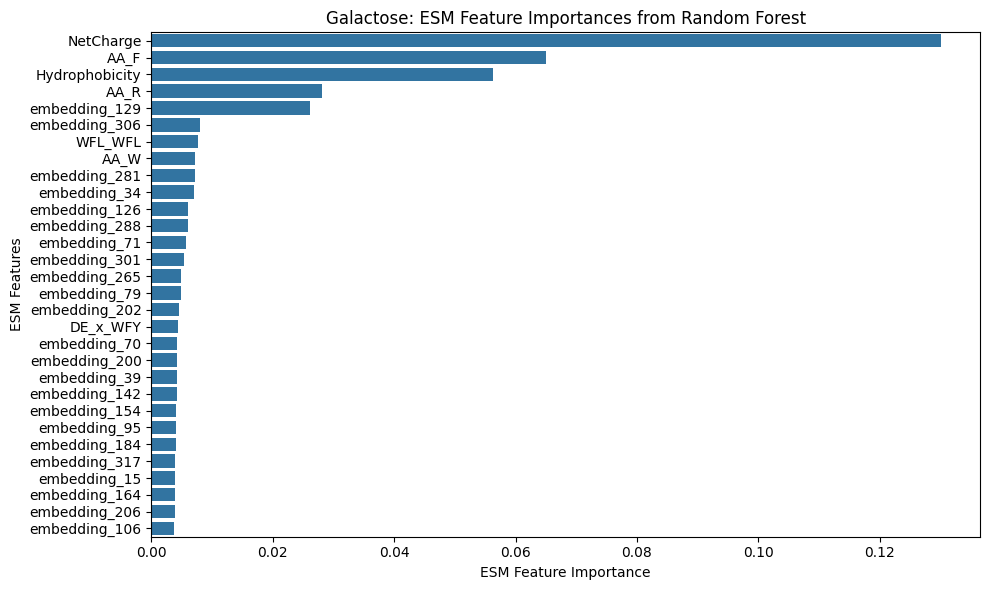

In [119]:
# Get feature importances from galactose Random Forest model
esm_feature_importances_gal = esm_random_forest_reg_gal.feature_importances_
esm_feature_names_gal = x_esm_gal.columns
esm_sorted_indices_gal = np.argsort(esm_feature_importances_gal)[::-1]

top_k = 30

sorted_esm_feature_importances_gal = esm_feature_importances_gal[esm_sorted_indices_gal][:top_k]
sorted_esm_feature_names_gal = esm_feature_names_gal[esm_sorted_indices_gal][:top_k]

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_esm_feature_importances_gal, y=sorted_esm_feature_names_gal)
plt.xlabel("ESM Feature Importance")
plt.ylabel("ESM Features")
plt.title("Galactose: ESM Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

In [120]:
joblib.dump(esm_random_forest_reg_gal, "./models/galactose/esm_random_forest_model_gal.pkl")

['./models/galactose/esm_random_forest_model_gal.pkl']

In [121]:
x_only_embeddings_gal = embeddings_df_gal.copy()
y_only_embeddings_gal = y_gal.copy()

In [122]:
x_only_embeddings_train_gal, x_only_embeddings_test_gal, y_only_embeddings_train_gal, y_only_embeddings_test_gal = train_test_split(
    x_only_embeddings_gal, y_only_embeddings_gal, test_size=0.2, random_state=42)

In [123]:
# Linear Regression
linear_reg_embeddings_gal = make_pipeline(StandardScaler(), LinearRegression())
linear_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
linear_reg_embeddings_y_pred_gal = linear_reg_embeddings_gal.predict(x_only_embeddings_test_gal)
print("Linear Regression with ESM Embeddings Results:")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal)[0]}")

Linear Regression with ESM Embeddings Results:
R^2: 0.41102474077522533
MAE: 31661.100293044856
RMSE: 41304.34583352428
Pearson Correlation: 0.6459048759875281


In [124]:
# Ridge Regression for Galactose
ridge_reg_embeddings_gal = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
ridge_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
ridge_reg_embeddings_gal_y_pred = ridge_reg_embeddings_gal.predict(x_only_embeddings_test_gal)

print("Ridge Regression Results (Only ESM2 for Galactose):")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred)[0]}")

Ridge Regression Results (Only ESM2 for Galactose):
R^2: 0.4118080884120441
MAE: 31641.68404066971
RMSE: 41276.86893466072
Pearson Correlation: 0.64634926702358


In [125]:
# Lasso Regression for Galactose
lasso_reg_embeddings_gal = make_pipeline(StandardScaler(), Lasso(alpha=1.0, max_iter=100000))
lasso_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
lasso_reg_embeddings_gal_y_pred = lasso_reg_embeddings_gal.predict(x_only_embeddings_test_gal)

print("Lasso Regression Results (Only ESM2 for Galactose):")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred)[0]}")

Lasso Regression Results (Only ESM2 for Galactose):
R^2: 0.4116209729438731
MAE: 31646.320212094648
RMSE: 41283.433906354614
Pearson Correlation: 0.6462503402429511


In [126]:
# Gradient Boosting for Galactose
grad_boost_reg_embeddings_gal = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
grad_boost_reg_embeddings_gal_y_pred = grad_boost_reg_embeddings_gal.predict(x_only_embeddings_test_gal)

print("Gradient Boosting Regressor Results (Only ESM2 for Galactose):")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)[0]}")

Gradient Boosting Regressor Results (Only ESM2 for Galactose):
R^2: 0.40659076782305104
MAE: 32217.63252993981
RMSE: 41459.52973458211
Pearson Correlation: 0.6385388954411475


In [127]:
# Gradient Boosting for Galactose
grad_boost_reg_embeddings_gal = make_pipeline(StandardScaler(), GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
grad_boost_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
grad_boost_reg_embeddings_gal_y_pred = grad_boost_reg_embeddings_gal.predict(x_only_embeddings_test_gal)

print("Gradient Boosting Regressor Results (Only ESM2 for Galactose):")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)[0]}")

Gradient Boosting Regressor Results (Only ESM2 for Galactose):
R^2: 0.40659076782305104
MAE: 32217.63252993981
RMSE: 41459.52973458211
Pearson Correlation: 0.6385388954411475


In [128]:
# Random Forest Regression for Galactose
random_forest_reg_embeddings_gal = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42))
random_forest_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
random_forest_reg_embeddings_gal_y_pred = random_forest_reg_embeddings_gal.predict(x_only_embeddings_test_gal)

print("Random Forest Regressor Results (Only ESM2 for Galactose):")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred)[0]}")


Random Forest Regressor Results (Only ESM2 for Galactose):
R^2: 0.427122118119899
MAE: 31813.641240883695
RMSE: 40735.98760433255
Pearson Correlation: 0.6553885694121812


In [129]:
# Elastic Net
elastic_reg_embeddings_gal = make_pipeline(StandardScaler(), ElasticNet(alpha=1.0, l1_ratio=0.5, max_iter=100000))
elastic_reg_embeddings_gal.fit(x_only_embeddings_train_gal, y_only_embeddings_train_gal)
elastic_reg_embeddings_y_pred_gal = elastic_reg_embeddings_gal.predict(x_only_embeddings_test_gal)
print("Elastic Net Regression Results (Only ESM2):")
print(f"R^2: {r2_score(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)}")
print(f"MAE: {mean_absolute_error(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)}")
print(f"RMSE: {root_mean_squared_error(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)}")
print(f"Pearson Correlation: {pearsonr(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)[0]}")

Elastic Net Regression Results (Only ESM2):
R^2: 0.395648177346005
MAE: 32797.08753255966
RMSE: 41840.04475774286
Pearson Correlation: 0.6306033345850633


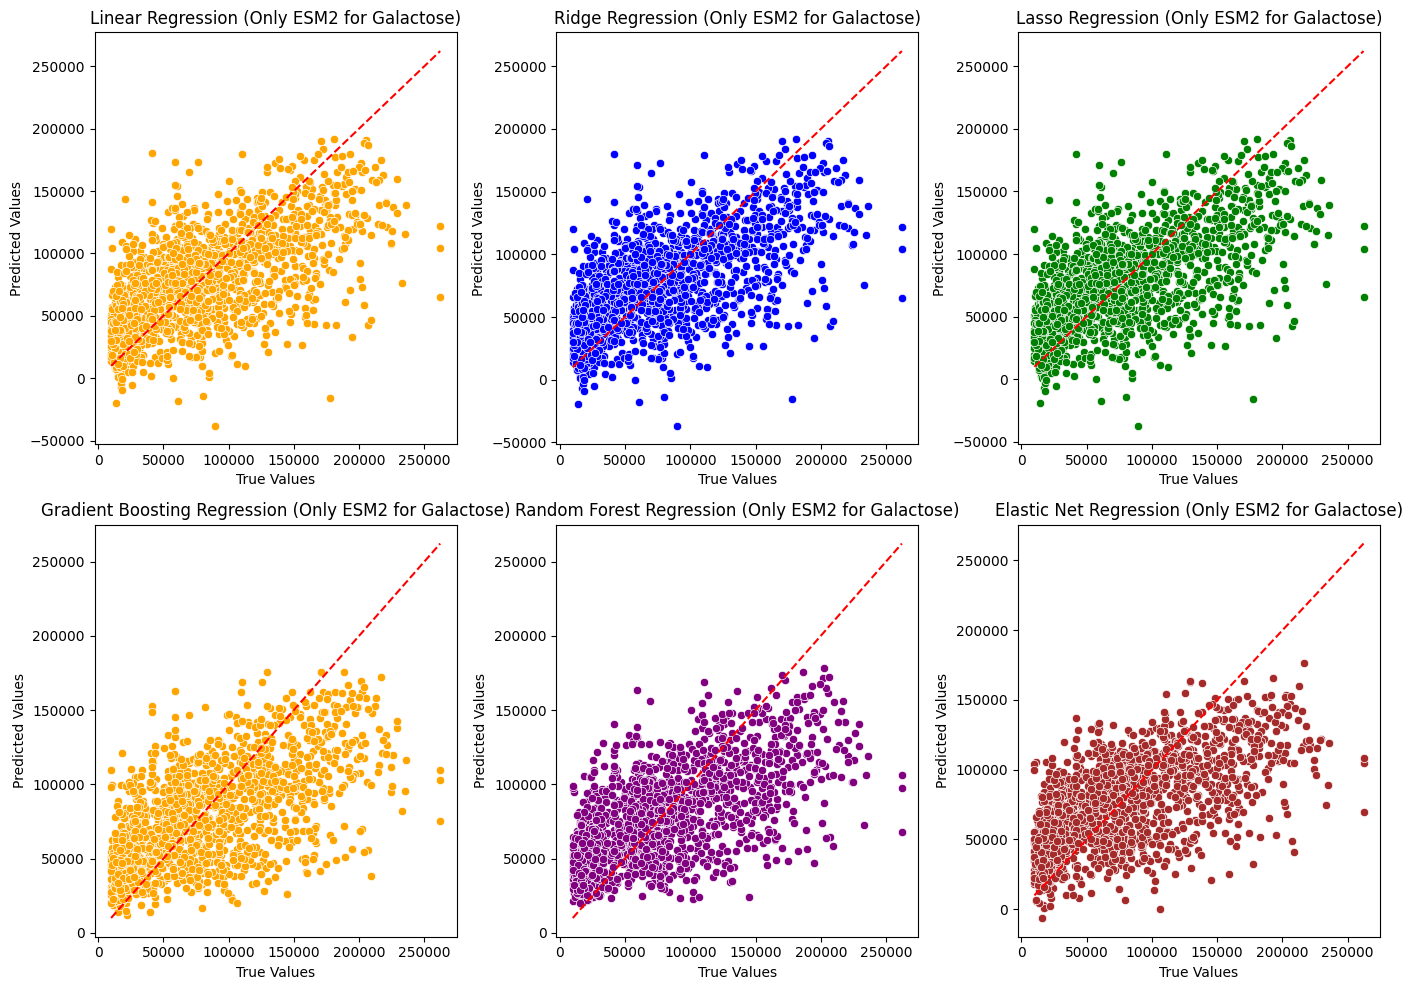

In [130]:
# subplots for Galactose
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

# Linear Regression
sns.scatterplot(x=y_only_embeddings_test_gal, y=linear_reg_embeddings_y_pred_gal, ax=axes[0], color='orange')
axes[0].set_title("Linear Regression (Only ESM2 for Galactose)")
axes[0].set_xlabel("True Values")
axes[0].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test_gal, y=y_only_embeddings_test_gal, ax=axes[0], color='red', linestyle='--')

# Ridge Regression (Galactose)
sns.scatterplot(x=y_only_embeddings_test_gal, y=ridge_reg_embeddings_gal_y_pred, ax=axes[1], color='blue')
axes[1].set_title("Ridge Regression (Only ESM2 for Galactose)")
axes[1].set_xlabel("True Values")
axes[1].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test_gal, y=y_only_embeddings_test_gal, ax=axes[1], color='red', linestyle='--')

# Lasso Regression (Galactose)
sns.scatterplot(x=y_only_embeddings_test_gal, y=lasso_reg_embeddings_gal_y_pred, ax=axes[2], color='green')
axes[2].set_title("Lasso Regression (Only ESM2 for Galactose)")
axes[2].set_xlabel("True Values")
axes[2].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test_gal, y=y_only_embeddings_test_gal, ax=axes[2], color='red', linestyle='--')

# Gradient Boosting Regression (Galactose)
sns.scatterplot(x=y_only_embeddings_test_gal, y=grad_boost_reg_embeddings_gal_y_pred, ax=axes[3], color='orange')
axes[3].set_title("Gradient Boosting Regression (Only ESM2 for Galactose)")
axes[3].set_xlabel("True Values")
axes[3].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test_gal, y=y_only_embeddings_test_gal, ax=axes[3], color='red', linestyle='--')

# Random Forest Regression (Galactose)
sns.scatterplot(x=y_only_embeddings_test_gal, y=random_forest_reg_embeddings_gal_y_pred, ax=axes[4], color='purple')
axes[4].set_title("Random Forest Regression (Only ESM2 for Galactose)")
axes[4].set_xlabel("True Values")
axes[4].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test_gal, y=y_only_embeddings_test_gal, ax=axes[4], color='red', linestyle='--')

# Elastic Net Regression
sns.scatterplot(x=y_only_embeddings_test_gal, y=elastic_reg_embeddings_y_pred_gal, ax=axes[5], color='brown')
axes[5].set_title("Elastic Net Regression (Only ESM2 for Galactose)")
axes[5].set_xlabel("True Values")
axes[5].set_ylabel("Predicted Values")
sns.lineplot(x=y_only_embeddings_test_gal, y=y_only_embeddings_test_gal, ax=axes[5], color='red', linestyle='--')

plt.tight_layout()
plt.show()

In [131]:
# Make results df for Galactose
only_embeddings_results_gal = {
    "Model": ["Linear (Only ESM2 for Galactose)", "Ridge (Only ESM2 for Galactose)", "Lasso (Only ESM2 for Galactose)", "Gradient Boosting (Only ESM2 for Galactose)", "Random Forest (Only ESM2 for Galactose)", "Elastic Net (Only ESM2 for Galactose)"],
    "R^2": [
        r2_score(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal),
        r2_score(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred),
        r2_score(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred),
        r2_score(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred),
        r2_score(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred),
        r2_score(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)
    ],
    "MAE": [
        mean_absolute_error(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal),
        mean_absolute_error(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred),
        mean_absolute_error(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred),
        mean_absolute_error(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred),
        mean_absolute_error(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred),
        mean_absolute_error(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)
    ],
    "RMSE": [
        root_mean_squared_error(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal),
        root_mean_squared_error(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred),
        root_mean_squared_error(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred),
        root_mean_squared_error(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred),
        root_mean_squared_error(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred),
        root_mean_squared_error(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)
    ],
    "Pearson Correlation": [
        pearsonr(y_only_embeddings_test_gal, linear_reg_embeddings_y_pred_gal)[0],
        pearsonr(y_only_embeddings_test_gal, ridge_reg_embeddings_gal_y_pred)[0],
        pearsonr(y_only_embeddings_test_gal, lasso_reg_embeddings_gal_y_pred)[0],
        pearsonr(y_only_embeddings_test_gal, grad_boost_reg_embeddings_gal_y_pred)[0],
        pearsonr(y_only_embeddings_test_gal, random_forest_reg_embeddings_gal_y_pred)[0],
        pearsonr(y_only_embeddings_test_gal, elastic_reg_embeddings_y_pred_gal)[0]
    ]
}

only_embeddings_results_df_gal = pd.DataFrame(only_embeddings_results_gal)
only_embeddings_results_df_gal = only_embeddings_results_df_gal.sort_values(by="R^2", ascending=False).reset_index(drop=True)
only_embeddings_results_df_gal.head(6)

Model       R^2           MAE  \
0      Random Forest (Only ESM2 for Galactose)  0.427122  31813.641241   
1              Ridge (Only ESM2 for Galactose)  0.411808  31641.684041   
2              Lasso (Only ESM2 for Galactose)  0.411621  31646.320212   
3             Linear (Only ESM2 for Galactose)  0.411025  31661.100293   
4  Gradient Boosting (Only ESM2 for Galactose)  0.406591  32217.632530   
5        Elastic Net (Only ESM2 for Galactose)  0.395648  32797.087533   

           RMSE  Pearson Correlation  
0  40735.987604             0.655389  
1  41276.868935             0.646349  
2  41283.433906             0.646250  
3  41304.345834             0.645905  
4  41459.529735             0.638539  
5  41840.044758             0.630603

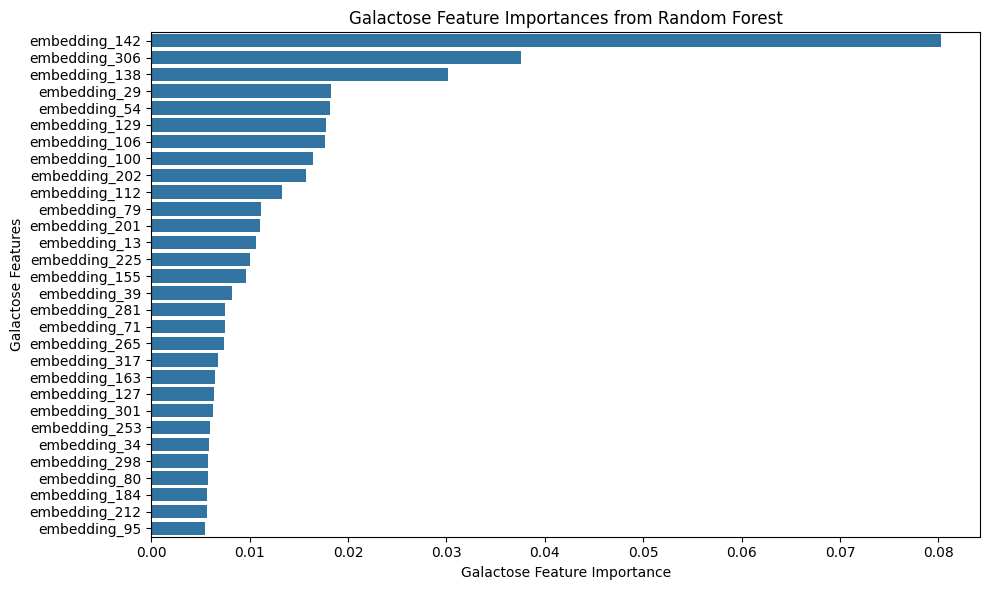

In [132]:
# feature importances for Galactose
only_embeddings_feature_importances_gal = random_forest_reg_embeddings_gal.named_steps['randomforestregressor'].feature_importances_
only_embeddings_feature_names_gal = x_only_embeddings_gal.columns
only_embeddings_sorted_indices_gal = np.argsort(only_embeddings_feature_importances_gal)[::-1]

top_k = 30

sorted_only_embeddings_feature_importances_gal = only_embeddings_feature_importances_gal[only_embeddings_sorted_indices_gal][:top_k]
sorted_only_embeddings_feature_names_gal = only_embeddings_feature_names_gal[only_embeddings_sorted_indices_gal][:top_k]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_only_embeddings_feature_importances_gal, y=sorted_only_embeddings_feature_names_gal)
plt.xlabel("Galactose Feature Importance")
plt.ylabel("Galactose Features")
plt.title("Galactose Feature Importances from Random Forest")
plt.tight_layout()
#plt.savefig("GCN4_feature_importances.png")
plt.show()

In [133]:
# Save the galactose model
joblib.dump(random_forest_reg_embeddings_gal, "./models/galactose/random_forest_model_only_embeddings_gal.pkl")

['./models/galactose/random_forest_model_only_embeddings_gal.pkl']

### Activity SCgalactose In Silico Directed Evolution

In [135]:
#Start off by importing the data

data = pd.read_csv("./data/gcn4-orthologs.csv")
data = data.rename(columns={data.columns[0]: "tile_id"})
data.head()

tile_id                                             DNAseq  \
0        0  AAAAATTCTAGATTTGTTTCTTTGATGCAAGGATTCTCTGATGGTT...   
1        1  AAAAATTCTCCATCTGGTTTGGCTCATTCTTCTGTTTCTGGTGTTG...   
2        2  AAACAAAATTCTCAAGTTGATCAATCTCCATTGTTGCCAGAAGAAG...   
3        3  AAACAAAGAGCTACTCCATTGACTCCAGTTGTTCCAGAATCTGATG...   
4        4  AAACAAAGATCTATTCCATTGTCTCCAATTGTTCCAGAATCTTCTG...   

                                      ADseq  numreads_per_AD_7AGFP_AAS  \
0  KNSRFVSLMQGFSDGSKDIIDNEVREVGDFSVNKPPQADD                        NaN   
1  KNSPSGLAHSSVSGVGKSRRRKGPLPPITVQDPSDKTAIK                      942.0   
2  KQNSQVDQSPLLPEEELEVSEHLRRRRSGTATSPPAGGVR                        NaN   
3  KQRATPLTPVVPESDDPVALKRARNTEAARRSRARKLERM                      357.0   
4  KQRSIPLSPIVPESSDPAALKRARNTEAARRSRARKLQRM                      539.0   

   Activity_7AGFP_AAS  numreads_per_AD_8AmCh_AAS  Activity_8AmCh_AAS  \
0                 NaN                        NaN                 NaN   
1          709.606092                      367.0         2921.917252   
2                 NaN                        NaN                 NaN   
3         1039.469842                      342.0         1089.428196   
4         1081.980998                      627.0          622.131501   

   numreads_per_AD_9ARatio_AAS  Activity_9ARatio_AAS  \
0                          NaN                   NaN   
1                        601.0           22242.74698   
2                          NaN                   NaN   
3                        450.0           74251.36241   
4                        586.0           58872.95132   

   numreads_per_AD_10BRatio_AAS  ...  Activity_BYS4_BioRepAverage  \
0                        3151.0  ...                          NaN   
1                        6909.0  ...                  21968.05843   
2                        6577.0  ...                          NaN   
3                           NaN  ...                          NaN   
4                         128.0  ...                  95093.69451   

  Stdev_BYS4_BioReps Activity_SCglucose  Start  Recovered  \
0                NaN        11666.48682    341       True   
1        5849.143385        21968.05843    146       True   
2                NaN        21203.02478    326       True   
3                NaN        47244.41248    246       True   
4       13292.686710        95093.69451    211       True   

   Activity_SCgalactose  Activity_P3promoter  Activity_P14promoter  \
0           97250.68362                  NaN           11149.49032   
1           15516.96245          14570.13217           16872.28649   
2               0.00000          18274.98241           15702.60901   
3           92844.00000                  NaN                   NaN   
4           76399.62949                  NaN          125056.17980   

   Activity_P15promoter  Activity_P3promoterMig1TFBSremoved  
0                   NaN                         8040.343648  
1           11555.08411                        10255.296840  
2           18303.29201                        17265.783330  
3                   NaN                        84807.518160  
4          129302.35080                       100360.735500  

[5 rows x 35 columns]

In [136]:
# Sort by activity_SCgalactose
activity = "Activity_SCgalactose"
low_activity_df_gal = data.sort_values(by=[activity], ascending=True)
low_activity_df_gal = low_activity_df_gal[['ADseq', activity]].dropna()
low_activity_df_gal

ADseq  Activity_SCgalactose
8936   DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA                   0.0
15739  SGASLFAGLQNDSPWEAPASAFTTINPHSVSGSTRTISPK                   0.0
2024   TEARQNALNHRLQFDPASKLNKIQSTTIHDFSPLHTSAQP                   0.0
2030   TEAARRSRARKMERMNQLEEKVEGLVGINSEIIKENSNLK                   0.0
8994   DPVAVKRARNTEAARKSRARKLERQEEMERRIAELEKLLE                   0.0
...                                         ...                   ...
9074   DFSLGLDTTALDIAAALSQPKAKADVTPSSPMIRTTSSRA              262143.0
3439   RVSDSVSVPFGSGSTPSALFPKSLLSLPLVPRPAQATTTA              262143.0
11033  AARRSRARKMERMAQLEEKVEDLMNENSKMCDEVERLKAL              262143.0
17279  LRLSSSSRAGQPSSAAPLVNLGAISTSPLKMTFDSSNLNA              262143.0
18118  LFSTPLETDLSPLFDDIDVGVDAANWDSLFDEVPAEAPRE              262143.0

[19038 rows x 2 columns]

In [137]:
# Let's look at the min and max values of the activity
low_activity_df_gal.describe()

Activity_SCgalactose
count          19038.000000
mean           63422.829417
std            56236.541634
min                0.000000
25%            18045.696675
50%            50066.144585
75%            97417.912363
max           262143.000000

**In Silico Directed Evolution**
Without loss of generality, let's simply pick the protein sequence with the lowest activity and do some a random pointwise mutation. We then repeat this process across 
 generations. First I will add sequence features so that we can use the random forest model to predict the SCGlucose activity. The reason for this is because the model is very strict with the columns we provide for prediction. It must be named and ordered exactly the same as how we trained the model initially or scikit-learn will complain!

In [138]:
# Global constants reused for galactose
AA_LIST = 'ACDEFGHIKLMNPQRSTVWY'
AA_COLS = [f"AA_{aa}" for aa in AA_LIST]

KD_HYDROPHOBICITY = {
    'A': 1.8, 'C': 2.5, 'D': -3.5, 'E': -3.5, 'F': 2.8,
    'G': -0.4, 'H': -3.2, 'I': 4.5, 'K': -3.9, 'L': 3.8,
    'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5,
    'S': -0.8, 'T': -0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3
}

MOTIFS = [
    ("W..LF", "W..LF"),
    ("WFYL_WFYL", "[WFYL]..[WFYL][WFYL]"),
    ("WFL_WFL", "[WFL]..[WFL][WFL]"),
    ("DE_WFY", "[DE][WFY]"),
    ("DE_WF", "[DE][WF]"),
    ("DE_L", "[DE][L]"),
    ("DE_x_WFY", "[DE].[WFY]"),
    ("DE_xx_WFY", "[DE]..[WFY]"),
    ("FF", "FF"),
    ("F_F", "F.F"),
    ("F__F", "F..F"),
    ("FY_5x_FY", "[FY].....[FY]"),
    ("SP", "SP"),
    ("WFYL_3x_WFYL", "[WFYL]...[WFYL][WFYL]")
]

# Feature extraction functions
def amino_acid_count(sequence: str) -> dict[str, int]:
    c = Counter(sequence)
    return {f"AA_{aa}": c.get(aa, 0) for aa in AA_LIST}

def net_charge(seq: str) -> int:
    charge_map = {"K": 1, "R": 1, "D": -1, "E": -1}
    return sum(charge_map.get(a, 0) for a in seq)

def hydrophobicity(sequence: str) -> float:
    return sum(KD_HYDROPHOBICITY.get(aa, 0) for aa in sequence)

def motif_counts_dict(seq: str) -> dict[str, int]:
    return {name: len(re.findall(pat, seq)) for name, pat in MOTIFS}

# Galactose-specific application
def add_sequence_features_gal(df_gal: pd.DataFrame, seq_col: str = "ADseq") -> pd.DataFrame:
    df_gal = df_gal.copy()

    # Basic features
    aa_expanded = df_gal[seq_col].apply(amino_acid_count).apply(pd.Series)
    motif_expanded = df_gal[seq_col].apply(motif_counts_dict).apply(pd.Series)

    df_gal["NetCharge"] = df_gal[seq_col].apply(net_charge)
    df_gal["Hydrophobicity"] = df_gal[seq_col].apply(hydrophobicity)
    df_gal["Length"] = df_gal[seq_col].str.len()

    # Combine into one dataframe
    result_df_gal = pd.concat([df_gal, aa_expanded, motif_expanded], axis=1)
    return result_df_gal

In [139]:
low_activity_df_gal = add_sequence_features_gal(low_activity_df_gal, seq_col="ADseq")

# now we put Activity_SCglucose as the last column for convenience
low_activity_df_gal = low_activity_df_gal[[col for col in low_activity_df_gal.columns if col != activity] + [activity]]
low_activity_df_gal.head()

ADseq  NetCharge  Hydrophobicity  \
8936   DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA          4           -51.3   
15739  SGASLFAGLQNDSPWEAPASAFTTINPHSVSGSTRTISPK          0           -11.4   
2024   TEARQNALNHRLQFDPASKLNKIQSTTIHDFSPLHTSAQP          1           -35.2   
2030   TEAARRSRARKMERMNQLEEKVEGLVGINSEIIKENSNLK          2           -41.5   
8994   DPVAVKRARNTEAARKSRARKLERQEEMERRIAELEKLLE          3           -52.4   

       Length  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  ...  DE_L  DE_x_WFY  \
8936       40     6     0     4     3     1     0  ...     1         0   
15739      40     5     0     1     1     2     3  ...     0         0   
2024       40     4     0     2     1     2     0  ...     0         0   
2030       40     3     0     0     7     0     2  ...     0         0   
8994       40     6     0     1     8     0     0  ...     1         0   

       DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  \
8936           0   0    0     0         0   0             0   
15739          1   0    0     0         0   2             0   
2024           0   0    0     0         0   1             0   
2030           0   0    0     0         0   0             0   
8994           0   0    0     0         0   0             0   

       Activity_SCgalactose  
8936                    0.0  
15739                   0.0  
2024                    0.0  
2030                    0.0  
8994                    0.0  

[5 rows x 39 columns]

Great! Now what we're going to do is simply take the first row which corresponds to the ADseq with low SCglucose activity. We will also take note of its corresponding activity value for comparison later on!

In [140]:
protein_sequence_gal = low_activity_df_gal.iloc[0, 0]
activity_value_gal = low_activity_df_gal.iloc[0, -1]
print(f"Protein sequence for Galactose: {protein_sequence_gal}")
print(f"Activity value for Galactose: {activity_value_gal}")

Protein sequence for Galactose: DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA
Activity value for Galactose: 0.0


In [141]:
def simulate_mutations_over_generations_gal(
    initial_sequence_gal: str,
    aa_list: list[str],
    add_features_fn_gal,
    num_generations: int = 10,
    num_mutations_per_generation: int = 1_000,
    max_sequences_per_gen: int = 5_000,
):
    # Precompute the original disorder once
    original_disorder_gal = np.array(meta.predict_disorder(initial_sequence_gal))

    current_sequences_gal = [initial_sequence_gal]
    all_dfs_gal = []

    # Begin generation loop
    for gen in tqdm(range(num_generations), desc="Generation"):
        parent_count_gal = len(current_sequences_gal)
        total_events_gal = num_mutations_per_generation

        # Randomly select parents, positions, and new amino acids
        parents_gal   = np.random.randint(0, parent_count_gal, size=total_events_gal)
        positions_gal = np.random.randint(0, len(initial_sequence_gal), size=total_events_gal)
        new_aas_gal   = np.random.choice(aa_list, size=total_events_gal)

        # Generate mutated sequences (unique only)
        mutated_gal = {
            current_sequences_gal[p][:pos] + aa + current_sequences_gal[p][pos+1:]
            for p, pos, aa in zip(parents_gal, positions_gal, new_aas_gal)
        }

        mutated_list_gal = list(mutated_gal)
        tqdm.write(f"Gen {gen+1}: {len(mutated_list_gal)} unique mutants created")

        # Optional: filter based on similarity to original disorder
        if len(mutated_list_gal) > max_sequences_per_gen:
            distances_gal = []
            for seq in tqdm(mutated_list_gal, desc="Disorder scoring"):
                sc_gal = np.array(meta.predict_disorder(seq))
                distances_gal.append(np.linalg.norm(sc_gal - original_disorder_gal))
            distances_gal = np.array(distances_gal)

            keep_idx_gal = np.argsort(distances_gal)[:max_sequences_per_gen]
            mutated_list_gal = [mutated_list_gal[i] for i in keep_idx_gal]
            tqdm.write(f"  → filtered down to {len(mutated_list_gal)} by disorder")

        # Add features
        df_gal = pd.DataFrame({"ADseq": mutated_list_gal})
        df_gal["Generation"] = gen + 1
        df_gal = add_features_fn_gal(df_gal, seq_col="ADseq")

        # Save for this generation
        all_dfs_gal.append(df_gal)
        current_sequences_gal = mutated_list_gal

    return pd.concat(all_dfs_gal, ignore_index=True)

In [142]:
result_gal = simulate_mutations_over_generations_gal(
    initial_sequence_gal=protein_sequence_gal, 
    aa_list=list(AA_LIST), 
    add_features_fn_gal=add_sequence_features_gal,  # make sure this is defined for galactose
    num_generations=5, 
    num_mutations_per_generation=5000
)

Generation:   0%|          | 0/5 [00:00<?, ?it/s]

Gen 1: 759 unique mutants created


Generation:  20%|██        | 1/5 [00:00<00:01,  3.97it/s]

Gen 2: 4878 unique mutants created


Generation:  40%|████      | 2/5 [00:01<00:02,  1.07it/s]

Gen 3: 4986 unique mutants created


Generation:  60%|██████    | 3/5 [00:03<00:02,  1.29s/it]

Gen 4: 4988 unique mutants created


Generation:  80%|████████  | 4/5 [00:05<00:01,  1.47s/it]

Gen 5: 4988 unique mutants created


Generation: 100%|██████████| 5/5 [00:06<00:00,  1.33s/it]


In [143]:
result_gal.head()

ADseq  Generation  NetCharge  \
0  DPNDTVAMKRARNTLAARKSRQRKMQRFDELEGKIAKLEA           1          5   
1  DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAELEA           1          2   
2  DPNDTVAMKRARNTLAARKSRQRKMQRFPELEDKIAKLEA           1          5   
3  DPNDTVRMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA           1          5   
4  DPNDTVAMKRPRNTLAARKSRQRKMQRFDELEDKIAKLEA           1          4   

   Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_WF  DE_L  \
0           -48.2      40     6     0     3     3     1  ...      0     1   
1           -50.9      40     6     0     4     4     1  ...      0     2   
2           -49.4      40     6     0     3     3     1  ...      0     1   
3           -57.6      40     5     0     4     3     1  ...      0     1   
4           -54.7      40     5     0     4     3     1  ...      0     1   

   DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  
0         0          0   0    0     0         0   0             0  
1         0          0   0    0     0         0   0             0  
2         0          0   0    0     0         0   0             0  
3         0          0   0    0     0         0   0             0  
4         0          0   0    0     0         0   0             0  

[5 rows x 39 columns]

In [144]:
# ==========================
# ESM2 Feature Embedding Computation
# ==========================

# Load the .env file
load_dotenv()
hf_token = os.getenv("HF_TOKEN")

# Load model and tokenizer once
model_id = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModel.from_pretrained(model_id, token=hf_token)
model.eval()

def generate_embedding(sequence):
    """Generate pooled ESM embedding for a protein sequence."""
    input_ids = tokenizer(sequence, return_tensors="pt").input_ids
    attention_mask = torch.ones_like(input_ids)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        sequence_embeddings = outputs.last_hidden_state.squeeze()

    # Remove special tokens [CLS], [EOS]
    sequence_embeddings = sequence_embeddings[1:-1]

    # Mean-pool across residues
    pooled_embedding = sequence_embeddings.mean(dim=0)  # shape: (hidden_size,)
    return pooled_embedding.cpu().numpy()

def save_embeddings_to_npz(data, sequence_column, save_path):
    """Generate embeddings for all sequences and save into a single NPZ file."""
    all_embeddings = []

    for sequence in tqdm(data[sequence_column], desc="Generating embeddings"):
        embedding = generate_embedding(sequence)
        all_embeddings.append(embedding)

    all_embeddings = np.stack(all_embeddings)  # Shape: (num_sequences, hidden_dim)

    np.savez_compressed(save_path, embeddings=all_embeddings)
    print(f"Saved {len(all_embeddings)} embeddings to {save_path}")

    return all_embeddings

/home/qamil/.pyenv/versions/3.11.9/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [145]:
result_gal.head()

ADseq  Generation  NetCharge  \
0  DPNDTVAMKRARNTLAARKSRQRKMQRFDELEGKIAKLEA           1          5   
1  DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAELEA           1          2   
2  DPNDTVAMKRARNTLAARKSRQRKMQRFPELEDKIAKLEA           1          5   
3  DPNDTVRMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA           1          5   
4  DPNDTVAMKRPRNTLAARKSRQRKMQRFDELEDKIAKLEA           1          4   

   Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_WF  DE_L  \
0           -48.2      40     6     0     3     3     1  ...      0     1   
1           -50.9      40     6     0     4     4     1  ...      0     2   
2           -49.4      40     6     0     3     3     1  ...      0     1   
3           -57.6      40     5     0     4     3     1  ...      0     1   
4           -54.7      40     5     0     4     3     1  ...      0     1   

   DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  
0         0          0   0    0     0         0   0             0  
1         0          0   0    0     0         0   0             0  
2         0          0   0    0     0         0   0             0  
3         0          0   0    0     0         0   0             0  
4         0          0   0    0     0         0   0             0  

[5 rows x 39 columns]

In [147]:
model_name = "./models/galactose/esm_random_forest_model_gal.pkl"

# Load the regression model
reg_model = joblib.load(model_name)

if model_name.split("/")[-1].split("_")[0] == "esm":
    mutated_seq_embeddings = save_embeddings_to_npz(result_gal, "ADseq", "./feature-embeddings/mutated_seq_embeddings.npz")
    embeddings_df = pd.DataFrame(mutated_seq_embeddings)
    embeddings_df.columns = [f"embedding_{i}" for i in range(embeddings_df.shape[1])]
    mutated_feature =result_gal.drop(columns=["ADseq", "Generation"])   
    mutated_feature = pd.concat([mutated_feature, embeddings_df], axis=1)
    
else: 
    mutated_feature = result_gal.drop(columns=["ADseq", "Generation"])

# Make predictions on the mutated sequence
predictions = reg_model.predict(mutated_feature)

# Add predictions to the DataFrame
result_gal[activity] = predictions

result_gal.head()

Generating embeddings: 100%|██████████| 20599/20599 [04:02<00:00, 85.06it/s] 


Saved 20599 embeddings to ./feature-embeddings/mutated_seq_embeddings.npz


ADseq  Generation  NetCharge  \
0  DPNDTVAMKRARNTLAARKSRQRKMQRFDELEGKIAKLEA           1          5   
1  DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAELEA           1          2   
2  DPNDTVAMKRARNTLAARKSRQRKMQRFPELEDKIAKLEA           1          5   
3  DPNDTVRMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA           1          5   
4  DPNDTVAMKRPRNTLAARKSRQRKMQRFDELEDKIAKLEA           1          4   

   Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_L  DE_x_WFY  \
0           -48.2      40     6     0     3     3     1  ...     1         0   
1           -50.9      40     6     0     4     4     1  ...     2         0   
2           -49.4      40     6     0     3     3     1  ...     1         0   
3           -57.6      40     5     0     4     3     1  ...     1         0   
4           -54.7      40     5     0     4     3     1  ...     1         0   

   DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  Activity_SCgalactose  
0          0   0    0     0         0   0             0          36286.189740  
1          0   0    0     0         0   0             0          39036.654895  
2          0   0    0     0         0   0             0          59509.566612  
3          0   0    0     0         0   0             0          47421.243220  
4          0   0    0     0         0   0             0          43040.576787  

[5 rows x 40 columns]

Naturally the next thing to do is to find which of these mutations is predicted to have the highest scglucose_activity. We'll then perform a more thorough analysis on this sequence

In [156]:
highest_activity_candidates = result_gal.sort_values(by=[activity], ascending=False)
highest_activity_candidates

ADseq  Generation  NetCharge  \
17215  DENDTLAMKRRRNTSAARKSRQRKMQRFDELEDKIVKLEA           5          4   
20316  DNNDTVDMKRARNTLIARKIRQRKMQRFDELEDKIAKLEA           5          3   
16112  RPNCTVAMKRRRNTLAARKSRQKKMQRFDELEDKIAKLEA           5          8   
14026  DPNNTVAMKRAKNTLAARKLRNRKMQRFDELEDKIAKLEA           4          5   
18876  YHNDTVAMKRARNTLAARKIRQRKMQRVDELEDKIAKLEA           5          5   
...                                         ...         ...        ...   
3003   DPNDTVAMHRARNTLAARKSRQRKMQRFDELEAKIAKLEA           2          4   
2067   DPNDTVAMHRERNTLAARKSRQRKMQRFDELEDKIAKLEA           2          2   
11727  DPNDTVAMKRARTTLAARKSRQRSMQRFDELEDKIAKLEG           4          3   
14508  DPNDTVAMHRARNTLAARKSRQRKMQRFDELEKKIAKLEE           4          4   
4808   DPNDYVAMGRARNTLAARKSRQRKMQRFDELEDKIAKLEA           2          3   

       Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_L  \
17215           -62.1      40     4     0     4     4     1  ...     1   
20316           -50.5      40     4     0     5     3     1  ...     1   
16112           -52.0      40     5     1     2     3     1  ...     1   
14026           -46.1      40     6     0     3     3     1  ...     1   
18876           -44.0      40     6     0     3     3     0  ...     1   
...               ...     ...   ...   ...   ...   ...   ...  ...   ...   
3003            -45.3      40     7     0     3     3     1  ...     1   
2067            -55.9      40     5     0     4     4     1  ...     1   
11727           -47.6      40     5     0     4     3     1  ...     1   
14508           -56.3      40     5     0     3     4     1  ...     1   
4808            -48.4      40     6     0     4     3     1  ...     1   

       DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  \
17215         0          0   0    0     0         0   0             0   
20316         0          0   0    0     0         0   0             0   
16112         0          0   0    0     0         0   0             0   
14026         0          0   0    0     0         0   0             0   
18876         0          0   0    0     0         0   0             0   
...         ...        ...  ..  ...   ...       ...  ..           ...   
3003          0          0   0    0     0         0   0             0   
2067          0          0   0    0     0         0   0             0   
11727         0          0   0    0     0         0   0             0   
14508         0          0   0    0     0         0   0             0   
4808          0          0   0    0     0         0   0             0   

       Activity_SCgalactose  
17215         158936.883464  
20316         156832.627042  
16112         149743.740687  
14026         145624.343221  
18876         144572.246975  
...                     ...  
3003           26647.001047  
2067           26268.224094  
11727          26266.855159  
14508          25986.188439  
4808           24907.628122  

[20599 rows x 40 columns]

In [157]:
top_500 = highest_activity_candidates.head(500)
top_500.head()

ADseq  Generation  NetCharge  \
17215  DENDTLAMKRRRNTSAARKSRQRKMQRFDELEDKIVKLEA           5          4   
20316  DNNDTVDMKRARNTLIARKIRQRKMQRFDELEDKIAKLEA           5          3   
16112  RPNCTVAMKRRRNTLAARKSRQKKMQRFDELEDKIAKLEA           5          8   
14026  DPNNTVAMKRAKNTLAARKLRNRKMQRFDELEDKIAKLEA           4          5   
18876  YHNDTVAMKRARNTLAARKIRQRKMQRVDELEDKIAKLEA           5          5   

       Hydrophobicity  Length  AA_A  AA_C  AA_D  AA_E  AA_F  ...  DE_L  \
17215           -62.1      40     4     0     4     4     1  ...     1   
20316           -50.5      40     4     0     5     3     1  ...     1   
16112           -52.0      40     5     1     2     3     1  ...     1   
14026           -46.1      40     6     0     3     3     1  ...     1   
18876           -44.0      40     6     0     3     3     0  ...     1   

       DE_x_WFY  DE_xx_WFY  FF  F_F  F__F  FY_5x_FY  SP  WFYL_3x_WFYL  \
17215         0          0   0    0     0         0   0             0   
20316         0          0   0    0     0         0   0             0   
16112         0          0   0    0     0         0   0             0   
14026         0          0   0    0     0         0   0             0   
18876         0          0   0    0     0         0   0             0   

       Activity_SCgalactose  
17215         158936.883464  
20316         156832.627042  
16112         149743.740687  
14026         145624.343221  
18876         144572.246975  

[5 rows x 40 columns]

In [159]:
top_candidate = top_500.iloc[0]
print(f"Top candidate sequence: {top_candidate['ADseq']}")
print(f"Original sequence: {protein_sequence_gal}")
print(f"Original activity: {activity_value_gal}")
print(f"Predicted activity: {top_candidate[activity]}")

Top candidate sequence: DENDTLAMKRRRNTSAARKSRQRKMQRFDELEDKIVKLEA
Original sequence: DPNDTVAMKRARNTLAARKSRQRKMQRFDELEDKIAKLEA
Original activity: 0.0
Predicted activity: 158936.88346369987


In [151]:
# How these two are different
def compare_sequences(seq1: str, seq2: str) -> list[tuple[int, str, str]]:
    differences = []
    for i, (a, b) in enumerate(zip(seq1, seq2)):
        if a != b:
            differences.append((i, a, b))
    return differences
differences = compare_sequences(protein_sequence_gal, top_candidate["ADseq"])
print("Differences between original and top candidate:")
for pos, original_aa, new_aa in differences:
    print(f"Position {pos}: {original_aa} -> {new_aa}")

Differences between original and top candidate:
Position 1: P -> E
Position 5: V -> L
Position 10: A -> R
Position 14: L -> S
Position 35: A -> V


In [152]:
# Difference in net charge and hydrophobicity
original_net_charge = net_charge(protein_sequence_gal)
top_candidate_net_charge = net_charge(top_candidate["ADseq"])
print(f"Original net charge: {original_net_charge}")
print(f"Top candidate net charge: {top_candidate_net_charge}")
print(f"Net charge difference: {top_candidate_net_charge - original_net_charge}")


original_hydrophobicity = hydrophobicity(protein_sequence_gal)
top_candidate_hydrophobicity = hydrophobicity(top_candidate["ADseq"])
print(f"Original hydrophobicity: {original_hydrophobicity}")
print(f"Top candidate hydrophobicity: {top_candidate_hydrophobicity}")
print(f"Hydrophobicity difference: {top_candidate_hydrophobicity - original_hydrophobicity}")

Original net charge: 4
Top candidate net charge: 4
Net charge difference: 0
Original hydrophobicity: -51.30000000000001
Top candidate hydrophobicity: -62.10000000000001
Hydrophobicity difference: -10.799999999999997


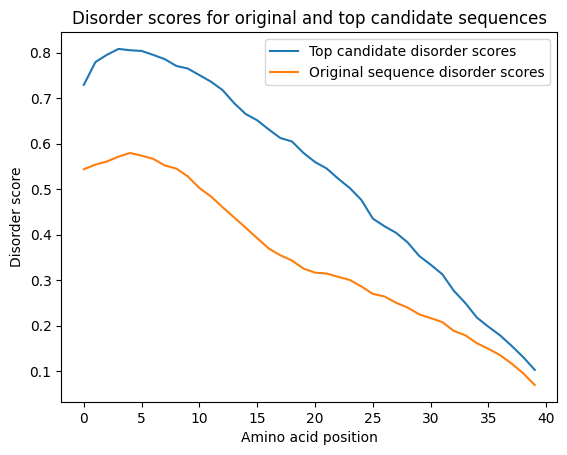

In [153]:
top_candidate_disorder_scores = meta.predict_disorder(top_candidate["ADseq"])
original_sequence_disorder_scores = meta.predict_disorder(protein_sequence_gal)

plt.plot(top_candidate_disorder_scores, label="Top candidate disorder scores")
plt.plot(original_sequence_disorder_scores, label="Original sequence disorder scores")
plt.xlabel("Amino acid position")
plt.ylabel("Disorder score")
plt.title("Disorder scores for original and top candidate sequences")
plt.legend()
plt.show()

In [ ]:
# Save the top 500 sequences to a CSV file
top_500.to_csv(f"./mutants/galactose/galactosetop_500_sequences_{activity}.csv", index=False)